# Real Hardware Fitting

In [1]:
import sys
sys.path.insert(0, '../../src_numpy/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)

## Expectation Value

### One Qubits, Manila

In [2]:
input_list, target_list = pickle.load(open("..\..\data\oneQubits_expectation.p", "rb"))
input_list, input_test = input_list[:18], input_list[18:]
target_list, target_test = target_list[:18], target_list[18:]

n = 1
d = 2**n
rank = 3

circuit = qk.QuantumCircuit(n)
circuit.h(0)
U = Operator(circuit).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(U=U, c=0.9, d=d, rank=rank)

model1 = ModelQuantumMap(q_map = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.05, 
                        h = 1e-3)

model1.train(num_iter = 1000, 
             use_adam = True,
             N = 18)

  0%|          | 0/1000 [00:00<?, ?it/s]

0: fid: 0.002, c: 0.904
1: fid: 0.001, c: 0.909
2: fid: 0.001, c: 0.912
3: fid: 0.001, c: 0.916
4: fid: 0.001, c: 0.919
5: fid: 0.001, c: 0.922
6: fid: 0.000, c: 0.924
7: fid: 0.000, c: 0.926
8: fid: 0.000, c: 0.927
9: fid: 0.000, c: 0.928
10: fid: 0.000, c: 0.929
11: fid: 0.000, c: 0.930
12: fid: 0.000, c: 0.930
13: fid: 0.000, c: 0.930
14: fid: 0.000, c: 0.929
15: fid: 0.000, c: 0.929
16: fid: 0.000, c: 0.928
17: fid: 0.000, c: 0.927
18: fid: 0.000, c: 0.927
19: fid: 0.000, c: 0.926
20: fid: 0.000, c: 0.925
21: fid: 0.000, c: 0.924
22: fid: 0.000, c: 0.923
23: fid: 0.000, c: 0.922
24: fid: 0.000, c: 0.922
25: fid: 0.000, c: 0.921
26: fid: 0.000, c: 0.921
27: fid: 0.000, c: 0.921
28: fid: 0.000, c: 0.921
29: fid: 0.000, c: 0.921
30: fid: 0.000, c: 0.922
31: fid: 0.000, c: 0.922
32: fid: 0.000, c: 0.922
33: fid: 0.000, c: 0.923
34: fid: 0.000, c: 0.923
35: fid: 0.000, c: 0.924
36: fid: 0.000, c: 0.924
37: fid: 0.000, c: 0.924
38: fid: 0.000, c: 0.924
39: fid: 0.000, c: 0.924
40: fid: 0

321: fid: 0.000, c: 0.921
322: fid: 0.000, c: 0.921
323: fid: 0.000, c: 0.921
324: fid: 0.000, c: 0.921
325: fid: 0.000, c: 0.921
326: fid: 0.000, c: 0.921
327: fid: 0.000, c: 0.921
328: fid: 0.000, c: 0.921
329: fid: 0.000, c: 0.921
330: fid: 0.000, c: 0.921
331: fid: 0.000, c: 0.921
332: fid: 0.000, c: 0.921
333: fid: 0.000, c: 0.921
334: fid: 0.000, c: 0.921
335: fid: 0.000, c: 0.921
336: fid: 0.000, c: 0.921
337: fid: 0.000, c: 0.921
338: fid: 0.000, c: 0.921
339: fid: 0.000, c: 0.921
340: fid: 0.000, c: 0.921
341: fid: 0.000, c: 0.921
342: fid: 0.000, c: 0.921
343: fid: 0.000, c: 0.921
344: fid: 0.000, c: 0.921
345: fid: 0.000, c: 0.921
346: fid: 0.000, c: 0.921
347: fid: 0.000, c: 0.921
348: fid: 0.000, c: 0.921
349: fid: 0.000, c: 0.921
350: fid: 0.000, c: 0.921
351: fid: 0.000, c: 0.921
352: fid: 0.000, c: 0.921
353: fid: 0.000, c: 0.921
354: fid: 0.000, c: 0.921
355: fid: 0.000, c: 0.921
356: fid: 0.000, c: 0.921
357: fid: 0.000, c: 0.921
358: fid: 0.000, c: 0.921
359: fid: 0.

637: fid: 0.000, c: 0.921
638: fid: 0.000, c: 0.921
639: fid: 0.000, c: 0.921
640: fid: 0.000, c: 0.921
641: fid: 0.000, c: 0.921
642: fid: 0.000, c: 0.921
643: fid: 0.000, c: 0.921
644: fid: 0.000, c: 0.921
645: fid: 0.000, c: 0.921
646: fid: 0.000, c: 0.921
647: fid: 0.000, c: 0.921
648: fid: 0.000, c: 0.921
649: fid: 0.000, c: 0.921
650: fid: 0.000, c: 0.921
651: fid: 0.000, c: 0.921
652: fid: 0.000, c: 0.921
653: fid: 0.000, c: 0.921
654: fid: 0.000, c: 0.921
655: fid: 0.000, c: 0.921
656: fid: 0.000, c: 0.921
657: fid: 0.000, c: 0.921
658: fid: 0.000, c: 0.921
659: fid: 0.000, c: 0.921
660: fid: 0.000, c: 0.921
661: fid: 0.000, c: 0.921
662: fid: 0.000, c: 0.921
663: fid: 0.000, c: 0.921
664: fid: 0.000, c: 0.921
665: fid: 0.000, c: 0.921
666: fid: 0.000, c: 0.921
667: fid: 0.000, c: 0.921
668: fid: 0.000, c: 0.921
669: fid: 0.000, c: 0.921
670: fid: 0.000, c: 0.921
671: fid: 0.000, c: 0.921
672: fid: 0.000, c: 0.921
673: fid: 0.000, c: 0.921
674: fid: 0.000, c: 0.921
675: fid: 0.

953: fid: 0.000, c: 0.921
954: fid: 0.000, c: 0.921
955: fid: 0.000, c: 0.921
956: fid: 0.000, c: 0.921
957: fid: 0.000, c: 0.921
958: fid: 0.000, c: 0.921
959: fid: 0.000, c: 0.921
960: fid: 0.000, c: 0.921
961: fid: 0.000, c: 0.921
962: fid: 0.000, c: 0.921
963: fid: 0.000, c: 0.921
964: fid: 0.000, c: 0.921
965: fid: 0.000, c: 0.921
966: fid: 0.000, c: 0.921
967: fid: 0.000, c: 0.921
968: fid: 0.000, c: 0.921
969: fid: 0.000, c: 0.921
970: fid: 0.000, c: 0.921
971: fid: 0.000, c: 0.921
972: fid: 0.000, c: 0.921
973: fid: 0.000, c: 0.921
974: fid: 0.000, c: 0.921
975: fid: 0.000, c: 0.921
976: fid: 0.000, c: 0.921
977: fid: 0.000, c: 0.921
978: fid: 0.000, c: 0.921
979: fid: 0.000, c: 0.921
980: fid: 0.000, c: 0.921
981: fid: 0.000, c: 0.921
982: fid: 0.000, c: 0.921
983: fid: 0.000, c: 0.921
984: fid: 0.000, c: 0.921
985: fid: 0.000, c: 0.921
986: fid: 0.000, c: 0.921
987: fid: 0.000, c: 0.921
988: fid: 0.000, c: 0.921
989: fid: 0.000, c: 0.921
990: fid: 0.000, c: 0.921
991: fid: 0.

In [5]:
circuit = qk.QuantumCircuit(n)
circuit.h(0)
U = Operator(circuit).data

state_unitary = state_model = observ = np.array([[1, 0], [0, 0]])
model_expectation_list = []
unitary_expectation_list = []

for i in range(20):
    state_model = model1.q_map.apply_map(state_model)
    model_expectation_list.append(expectation_value(state_model, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(state_unitary, observ))

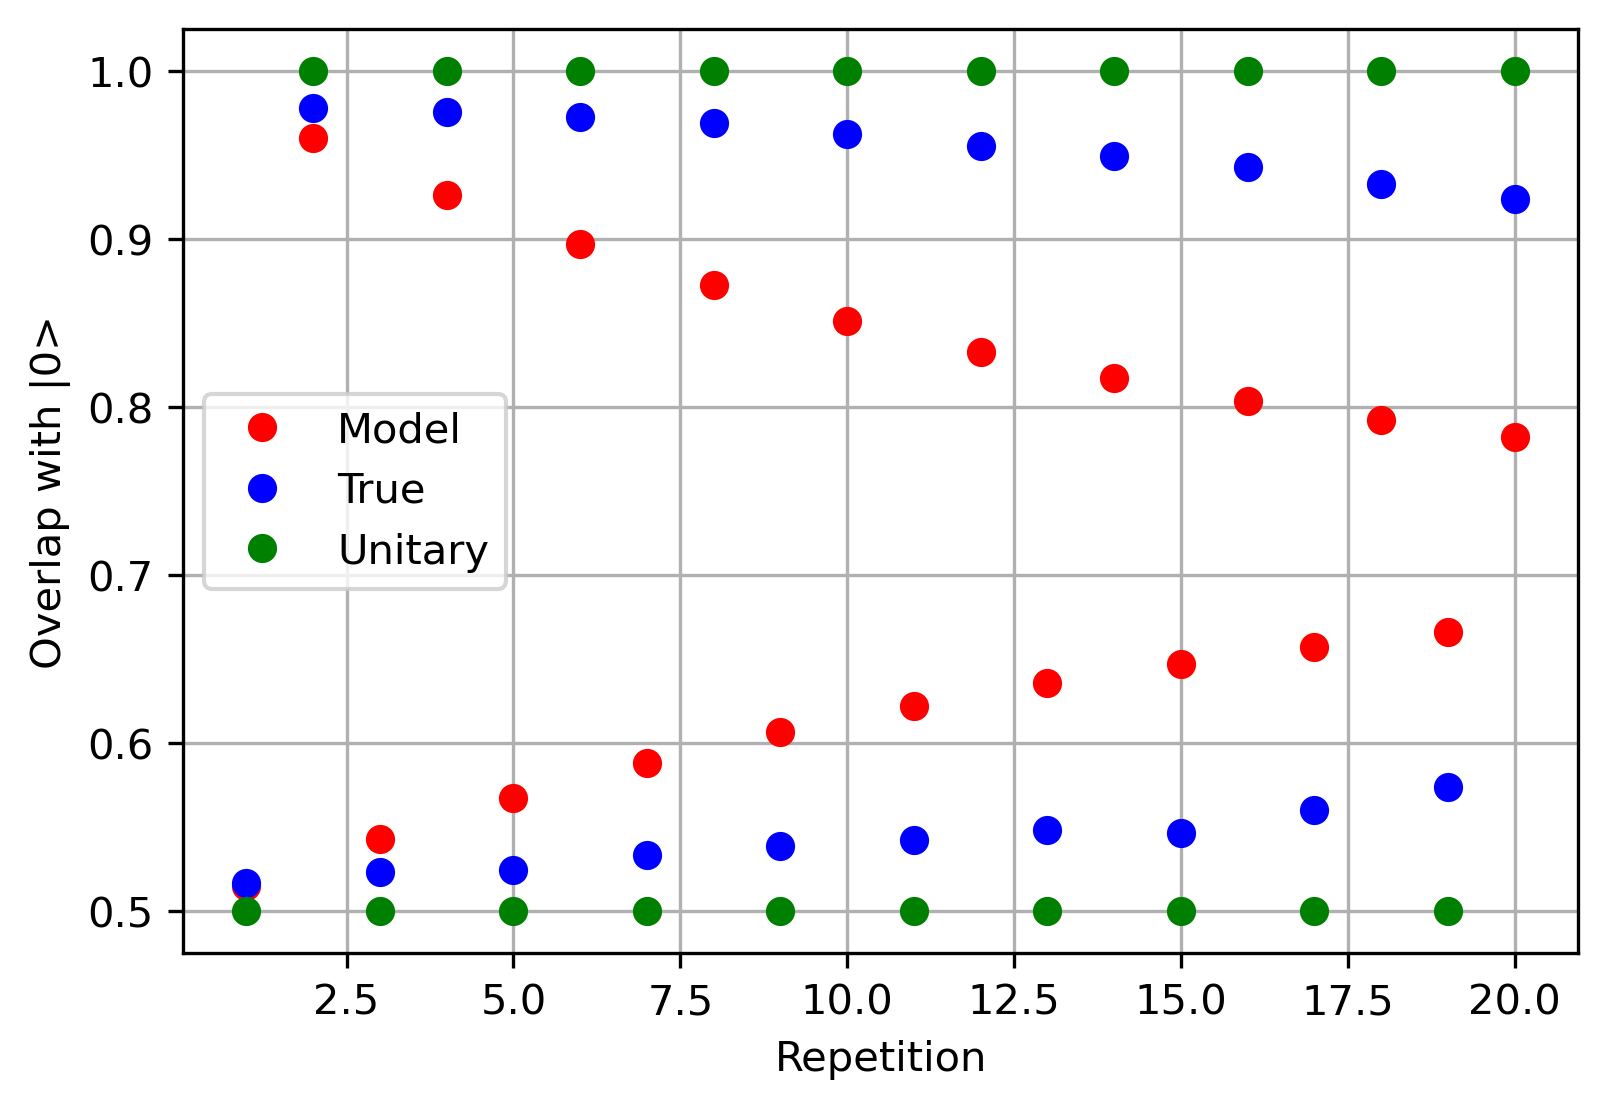

In [6]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, model_expectation_list, "ro", label="Model")
plt.plot(x, target_test, "bo", label="True")
plt.plot(x, unitary_expectation_list, "go", label="Unitary")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |0>")
plt.legend()
plt.grid()
plt.show()

## Two Qubits

In [61]:
input_list, target_list = pickle.load(open("..\..\data\twoQubits_expectation_400.p", "rb"))
input_list, input_test = input_list[:380], input_list[380:]
target_list, target_test = target_list[:380], target_list[380:]

input_val_list, target_val_list = pickle.load(open("..\..\data\twoQubits_expectation_380_540.p", "rb"))

input_list.extend(input_val_list)
target_list.extend(target_val_list)

input_val_list = input_val_list
target_val_list = target_val_list

print(len(input_val_list))
print(len(target_val_list))

n = 2
d = 2**n
rank = 7

np.random.seed(42)
random.seed(42)

circuit = qk.QuantumCircuit(n)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
U = Operator(circuit).data

kraus_model = KrausMap(U=U, c = 0.9, d=d, rank=rank)

model2 = ModelQuantumMap(q_map = kraus_model,
                         cost = expectation_value_loss,
                         input_list = input_list,
                         target_list = target_list,
                         input_val_list = input_list,
                         target_val_list = target_list,
                         lr = 0.05, 
                         h = 1e-3)

model2.train(num_iter = 1000, 
             use_adam = True,
             N = 40)

160
160


  0%|          | 0/1000 [00:00<?, ?it/s]

0: fid: 0.00356, c: 0.895
1: fid: 0.00346, c: 0.892
2: fid: 0.00336, c: 0.888
3: fid: 0.00327, c: 0.883
4: fid: 0.00319, c: 0.879
5: fid: 0.00312, c: 0.874
6: fid: 0.00306, c: 0.870
7: fid: 0.00300, c: 0.866
8: fid: 0.00296, c: 0.863
9: fid: 0.00292, c: 0.860
10: fid: 0.00287, c: 0.859
11: fid: 0.00282, c: 0.858
12: fid: 0.00277, c: 0.858
13: fid: 0.00272, c: 0.858
14: fid: 0.00267, c: 0.859
15: fid: 0.00262, c: 0.861
16: fid: 0.00257, c: 0.862
17: fid: 0.00252, c: 0.862
18: fid: 0.00247, c: 0.863
19: fid: 0.00243, c: 0.864
20: fid: 0.00239, c: 0.866
21: fid: 0.00236, c: 0.867
22: fid: 0.00232, c: 0.867
23: fid: 0.00228, c: 0.868
24: fid: 0.00225, c: 0.869
25: fid: 0.00221, c: 0.868
26: fid: 0.00218, c: 0.868
27: fid: 0.00214, c: 0.867
28: fid: 0.00210, c: 0.864
29: fid: 0.00205, c: 0.861
30: fid: 0.00201, c: 0.858
31: fid: 0.00198, c: 0.855
32: fid: 0.00194, c: 0.852
33: fid: 0.00191, c: 0.850
34: fid: 0.00188, c: 0.847
35: fid: 0.00185, c: 0.845
36: fid: 0.00182, c: 0.843
37: fid: 0.

297: fid: 0.00062, c: 0.725
298: fid: 0.00062, c: 0.725
299: fid: 0.00062, c: 0.725
300: fid: 0.00062, c: 0.726
301: fid: 0.00062, c: 0.725
302: fid: 0.00062, c: 0.724
303: fid: 0.00061, c: 0.723
304: fid: 0.00061, c: 0.723
305: fid: 0.00061, c: 0.721
306: fid: 0.00061, c: 0.720
307: fid: 0.00061, c: 0.719
308: fid: 0.00061, c: 0.717
309: fid: 0.00061, c: 0.715
310: fid: 0.00062, c: 0.713
311: fid: 0.00062, c: 0.711
312: fid: 0.00063, c: 0.710
313: fid: 0.00063, c: 0.710
314: fid: 0.00063, c: 0.711
315: fid: 0.00062, c: 0.713
316: fid: 0.00062, c: 0.714
317: fid: 0.00062, c: 0.715
318: fid: 0.00062, c: 0.717
319: fid: 0.00062, c: 0.719
320: fid: 0.00062, c: 0.722
321: fid: 0.00062, c: 0.725
322: fid: 0.00063, c: 0.728
323: fid: 0.00064, c: 0.731
324: fid: 0.00064, c: 0.730
325: fid: 0.00063, c: 0.730
326: fid: 0.00063, c: 0.728
327: fid: 0.00063, c: 0.726
328: fid: 0.00062, c: 0.723
329: fid: 0.00062, c: 0.720
330: fid: 0.00062, c: 0.717
331: fid: 0.00062, c: 0.715


KeyboardInterrupt: 

In [62]:
state_unitary = state_model = observ = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
model_expectation_list = []
unitary_expectation_list = []

for i in range(20):
    state_model = model2.map_best.apply_map(state_model)
    model_expectation_list.append(expectation_value(state_model, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(state_unitary, observ))

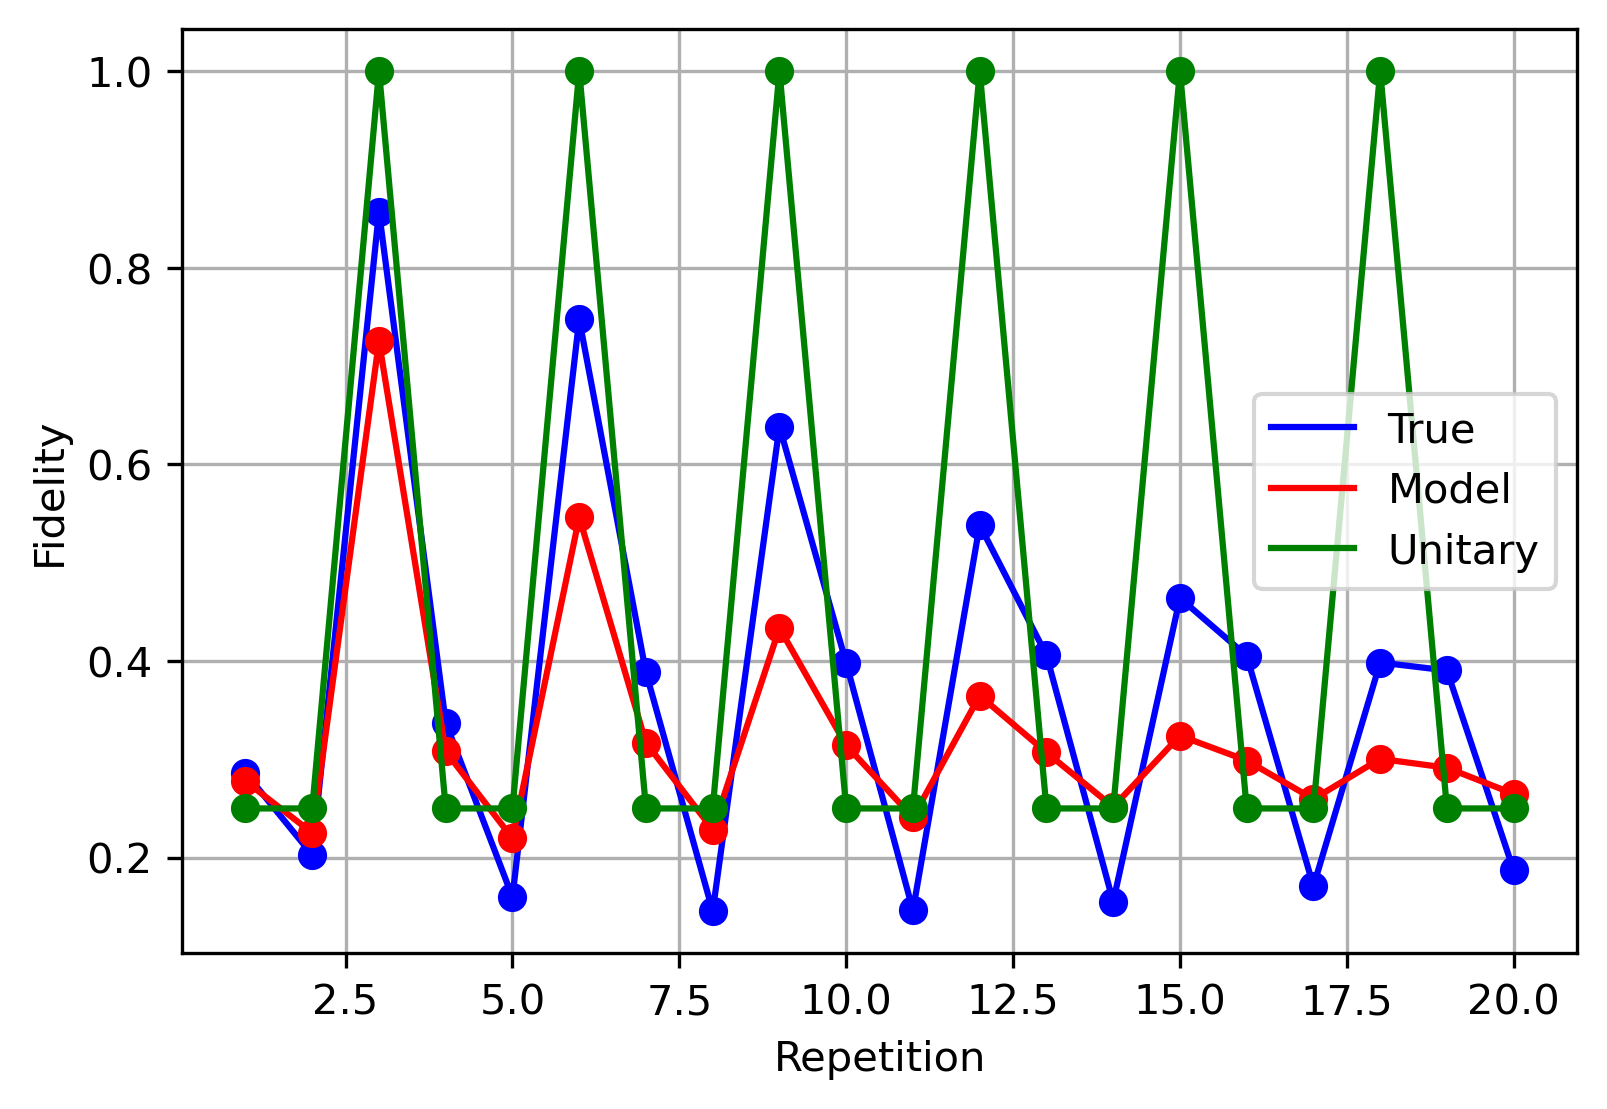

In [63]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Fidelity")
plt.legend()
plt.grid()
plt.show()

## Two Qubits Error Correction

In [2]:
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_error.p", "rb"))
counts_error = counts_list[-32:]
corr_mat = sum([generate_corruption_matrix(counts_error[4*i:4*(i+1)]) for i in range(8)])/8
print(np.sum(corr_mat, axis=0))

povm = corr_mat_to_povm(corr_mat)
print(povm[0].T@povm[0])

[1. 1. 1. 1.]
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [3]:
n = 2
d = 2**n
rank = 7

np.random.seed(42)
random.seed(42)

circuit = qk.QuantumCircuit(n)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
U = Operator(circuit).data

kraus_model = KrausMap(U=U, 
                       c = 0.9, 
                       d=d, 
                       rank=rank, 
                       povm = povm
                      )

model = ModelQuantumMap(q_map = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        lr = 0.05, 
                        h = 1e-3)

NameError: name 'target_list' is not defined

In [45]:
model.train(num_iter = 500, 
            use_adam = True,
            N = 100)

  0%|          | 0/500 [00:00<?, ?it/s]

0: fid: 0.00513, c: 0.904
1: fid: 0.00481, c: 0.909
2: fid: 0.00453, c: 0.913
3: fid: 0.00428, c: 0.916
4: fid: 0.00406, c: 0.920
5: fid: 0.00387, c: 0.924
6: fid: 0.00370, c: 0.927
7: fid: 0.00355, c: 0.930
8: fid: 0.00343, c: 0.932
9: fid: 0.00333, c: 0.935
10: fid: 0.00324, c: 0.937
11: fid: 0.00316, c: 0.939
12: fid: 0.00309, c: 0.941
13: fid: 0.00303, c: 0.943
14: fid: 0.00298, c: 0.944
15: fid: 0.00294, c: 0.946
16: fid: 0.00290, c: 0.947
17: fid: 0.00286, c: 0.948
18: fid: 0.00283, c: 0.949
19: fid: 0.00280, c: 0.950
20: fid: 0.00278, c: 0.951
21: fid: 0.00276, c: 0.952
22: fid: 0.00274, c: 0.952
23: fid: 0.00271, c: 0.953
24: fid: 0.00270, c: 0.954
25: fid: 0.00268, c: 0.954
26: fid: 0.00266, c: 0.954
27: fid: 0.00264, c: 0.955
28: fid: 0.00263, c: 0.955
29: fid: 0.00261, c: 0.955
30: fid: 0.00260, c: 0.955
31: fid: 0.00258, c: 0.955
32: fid: 0.00257, c: 0.955
33: fid: 0.00256, c: 0.955
34: fid: 0.00254, c: 0.955
35: fid: 0.00253, c: 0.955
36: fid: 0.00252, c: 0.955
37: fid: 0.

297: fid: 0.00129, c: 0.674
298: fid: 0.00129, c: 0.673
299: fid: 0.00129, c: 0.672
300: fid: 0.00129, c: 0.670
301: fid: 0.00129, c: 0.669
302: fid: 0.00129, c: 0.668
303: fid: 0.00129, c: 0.667
304: fid: 0.00130, c: 0.666
305: fid: 0.00130, c: 0.666
306: fid: 0.00131, c: 0.665
307: fid: 0.00131, c: 0.665
308: fid: 0.00131, c: 0.664
309: fid: 0.00132, c: 0.664
310: fid: 0.00132, c: 0.663
311: fid: 0.00131, c: 0.662
312: fid: 0.00130, c: 0.662
313: fid: 0.00130, c: 0.661
314: fid: 0.00129, c: 0.660
315: fid: 0.00129, c: 0.658
316: fid: 0.00128, c: 0.656
317: fid: 0.00128, c: 0.654
318: fid: 0.00128, c: 0.652
319: fid: 0.00129, c: 0.651
320: fid: 0.00129, c: 0.649
321: fid: 0.00129, c: 0.649
322: fid: 0.00129, c: 0.649
323: fid: 0.00129, c: 0.649
324: fid: 0.00129, c: 0.649
325: fid: 0.00130, c: 0.649
326: fid: 0.00130, c: 0.649
327: fid: 0.00129, c: 0.649
328: fid: 0.00130, c: 0.649
329: fid: 0.00131, c: 0.650
330: fid: 0.00132, c: 0.650
331: fid: 0.00132, c: 0.649
332: fid: 0.00132, c

KeyboardInterrupt: 

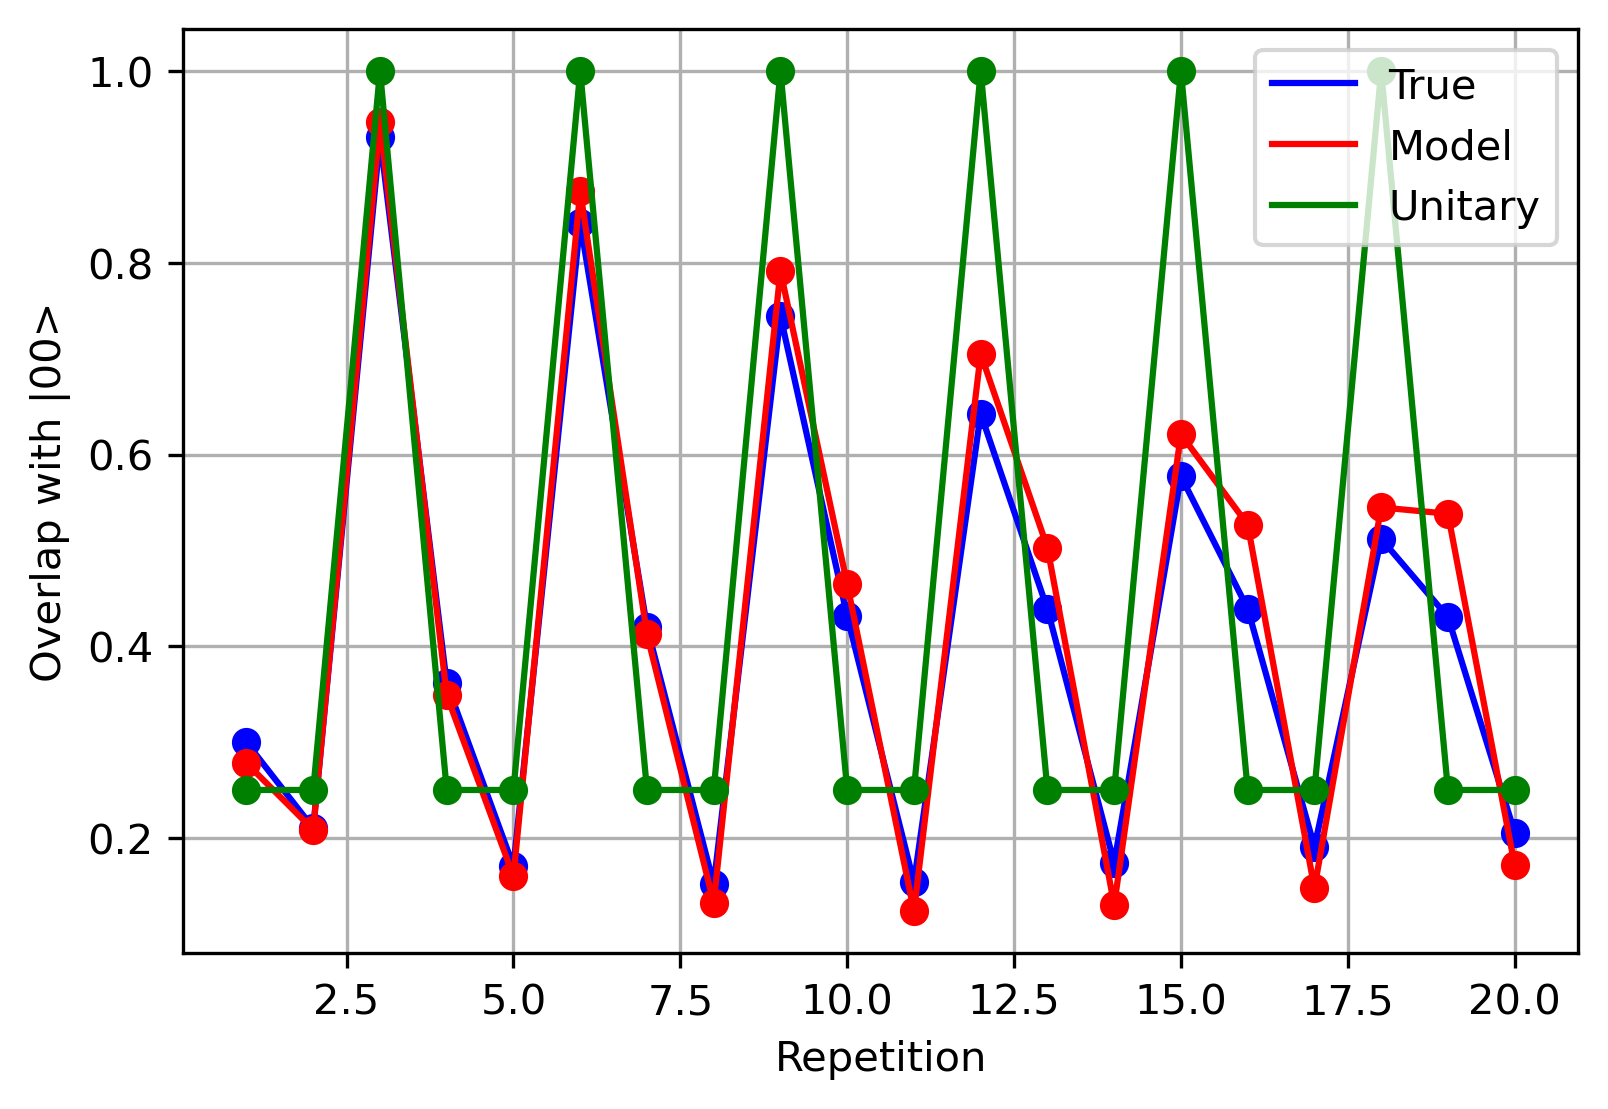

In [81]:
target_test = []
for counts in counts_list[324:-32]:
    vec = counts_to_vector(counts, 2)
    vec = corr_mat@vec
    counts = vector_to_counts(vec, 2)
    target_test.append(counts["00"])
    
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
model_expectation_list = []
unitary_expectation_list = []

for i in range(20):
    state_model = model.map_best.apply_map(state_model)
    model_expectation_list.append(expectation_value(state_model, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(state_unitary, observ))
    
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

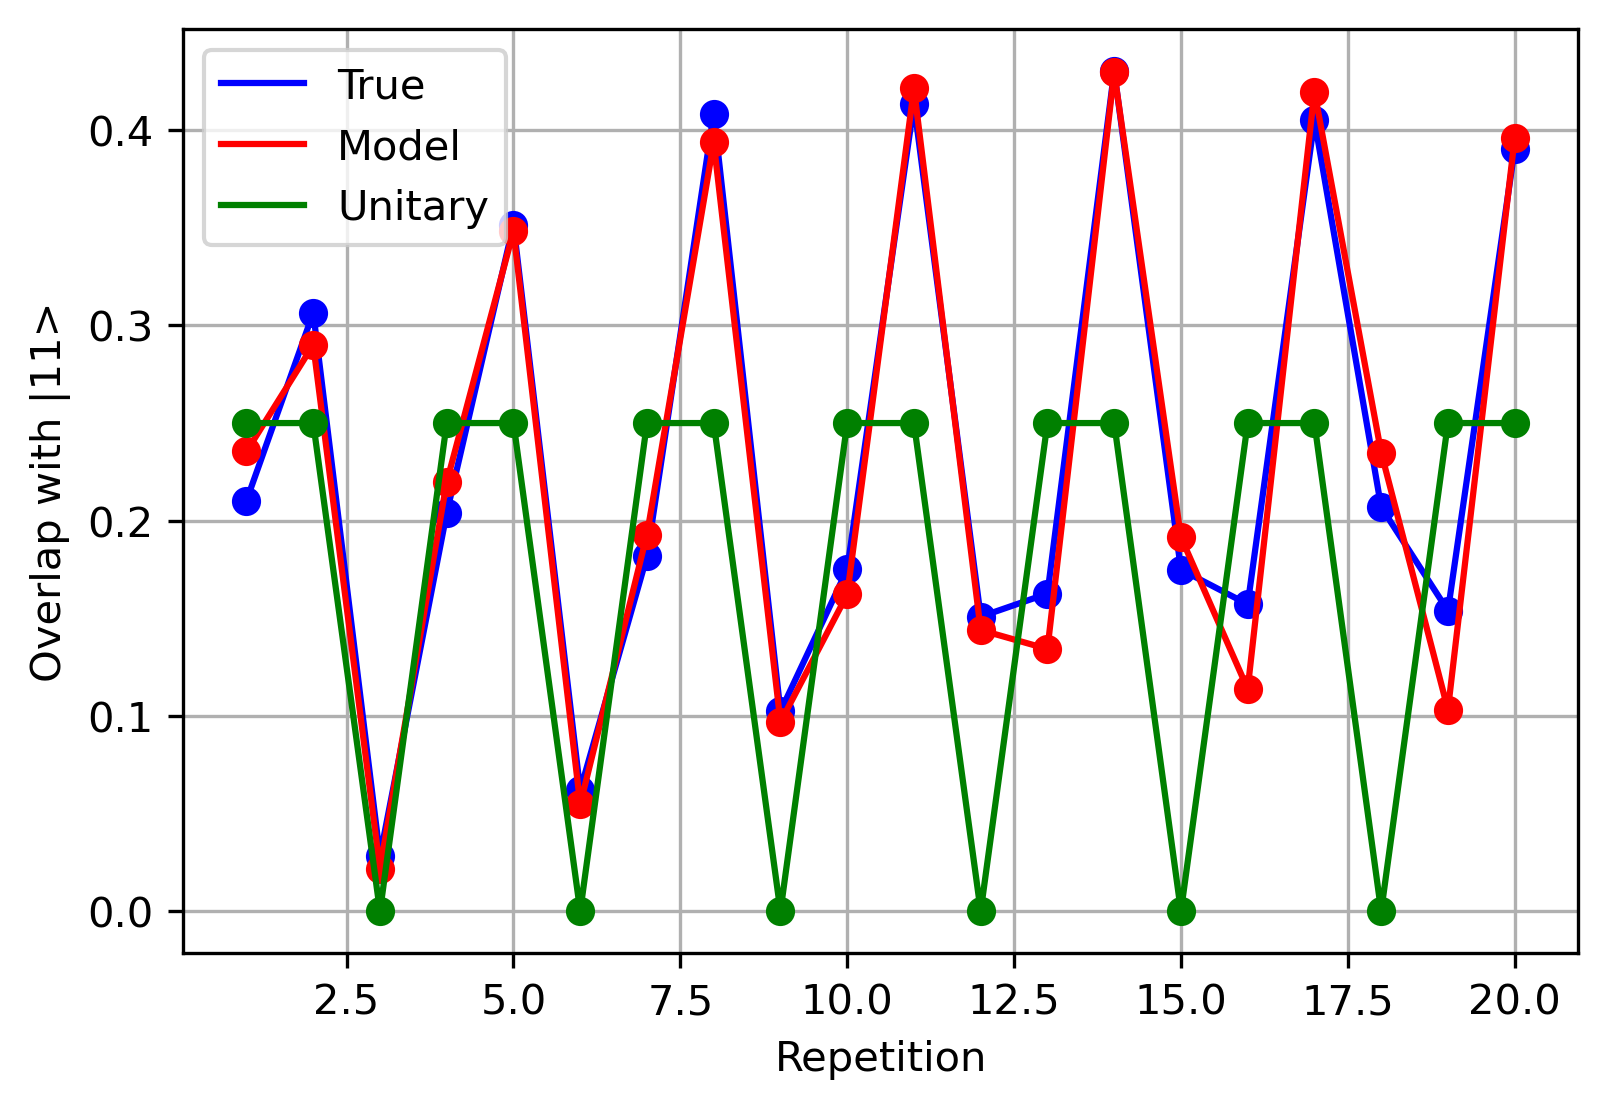

In [82]:
target_test = []
for counts in counts_list[324:-32]:
    vec = counts_to_vector(counts, 2)
    vec = corr_mat@vec
    counts = vector_to_counts(vec, 2)
    target_test.append(counts["11"])
    
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1]])
model_expectation_list = []
unitary_expectation_list = []

for i in range(20):
    state_model = model.map_best.apply_map(state_model)
    model_expectation_list.append(expectation_value(state_model, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(state_unitary, observ))
    
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |11>")
plt.legend()
plt.grid()
plt.show()

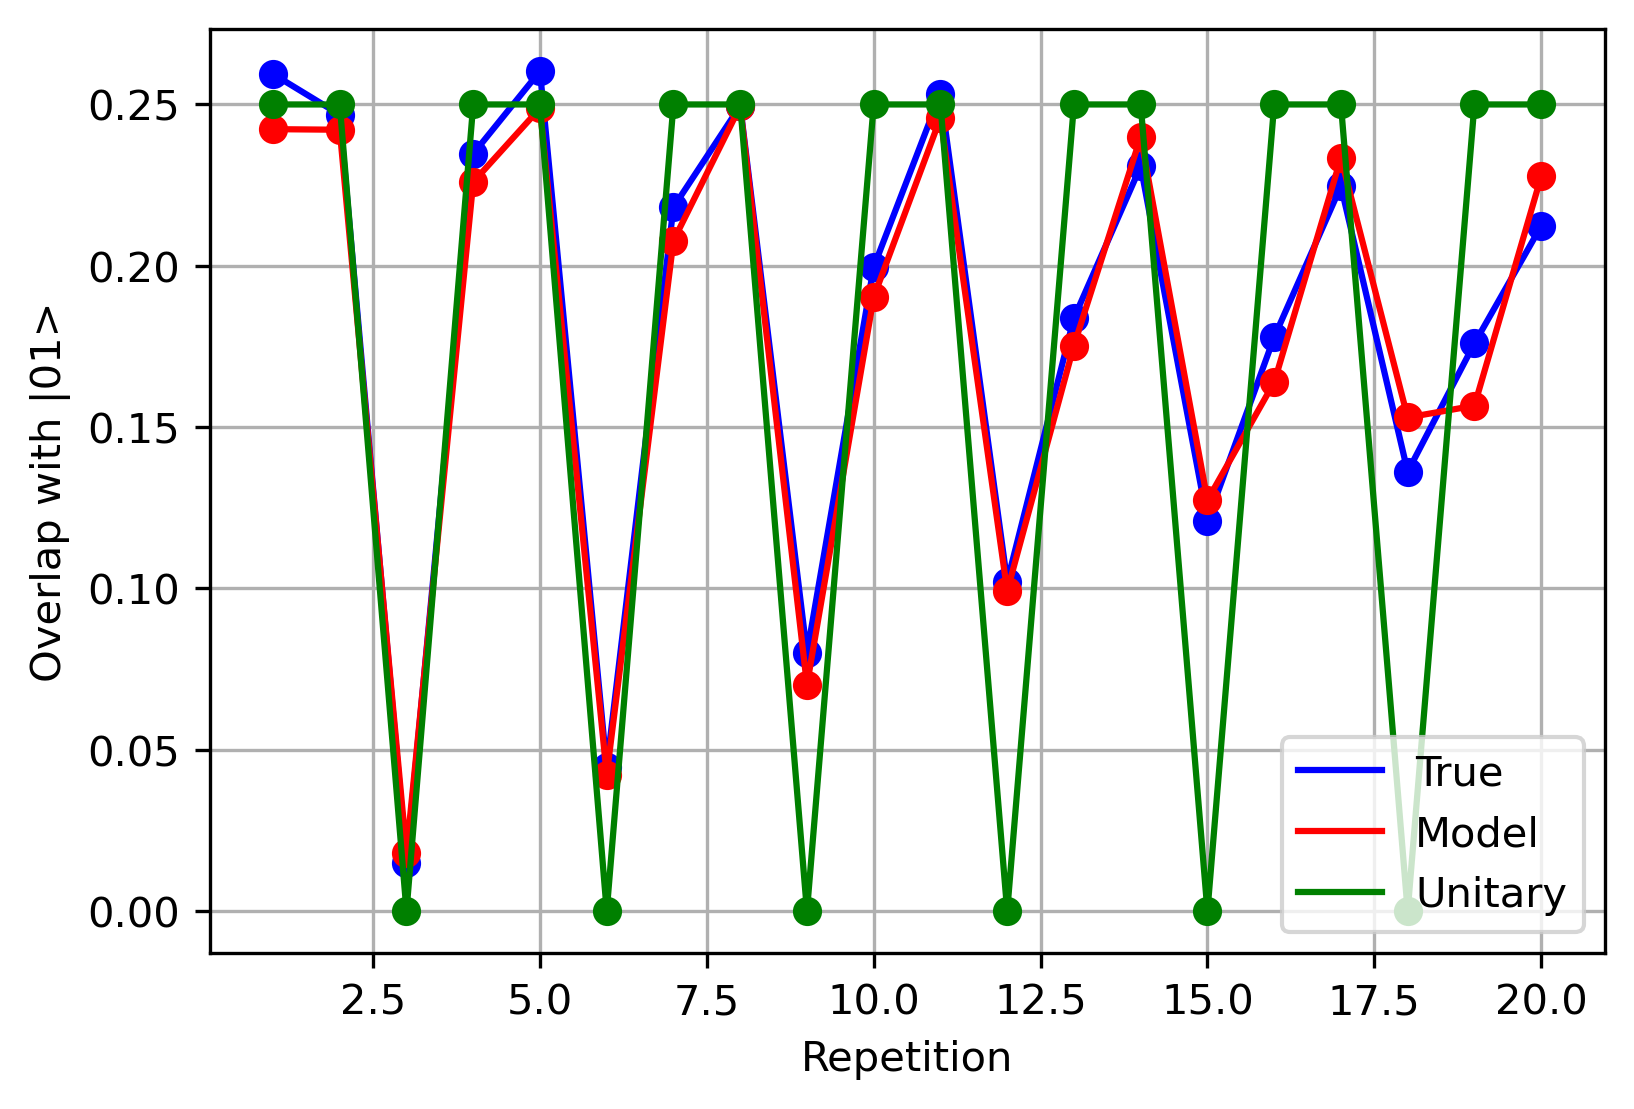

In [79]:
target_test = []
for counts in counts_list[324:-32]:
    vec = counts_to_vector(counts, 2)
    vec = corr_mat@vec
    counts = vector_to_counts(vec, 2)
    target_test.append(counts["01"])
    
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]])
model_expectation_list = []
unitary_expectation_list = []

for i in range(20):
    state_model = model.map_best.apply_map(state_model)
    model_expectation_list.append(expectation_value(state_model, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(state_unitary, observ))
    
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |01>")
plt.legend()
plt.grid()
plt.show()

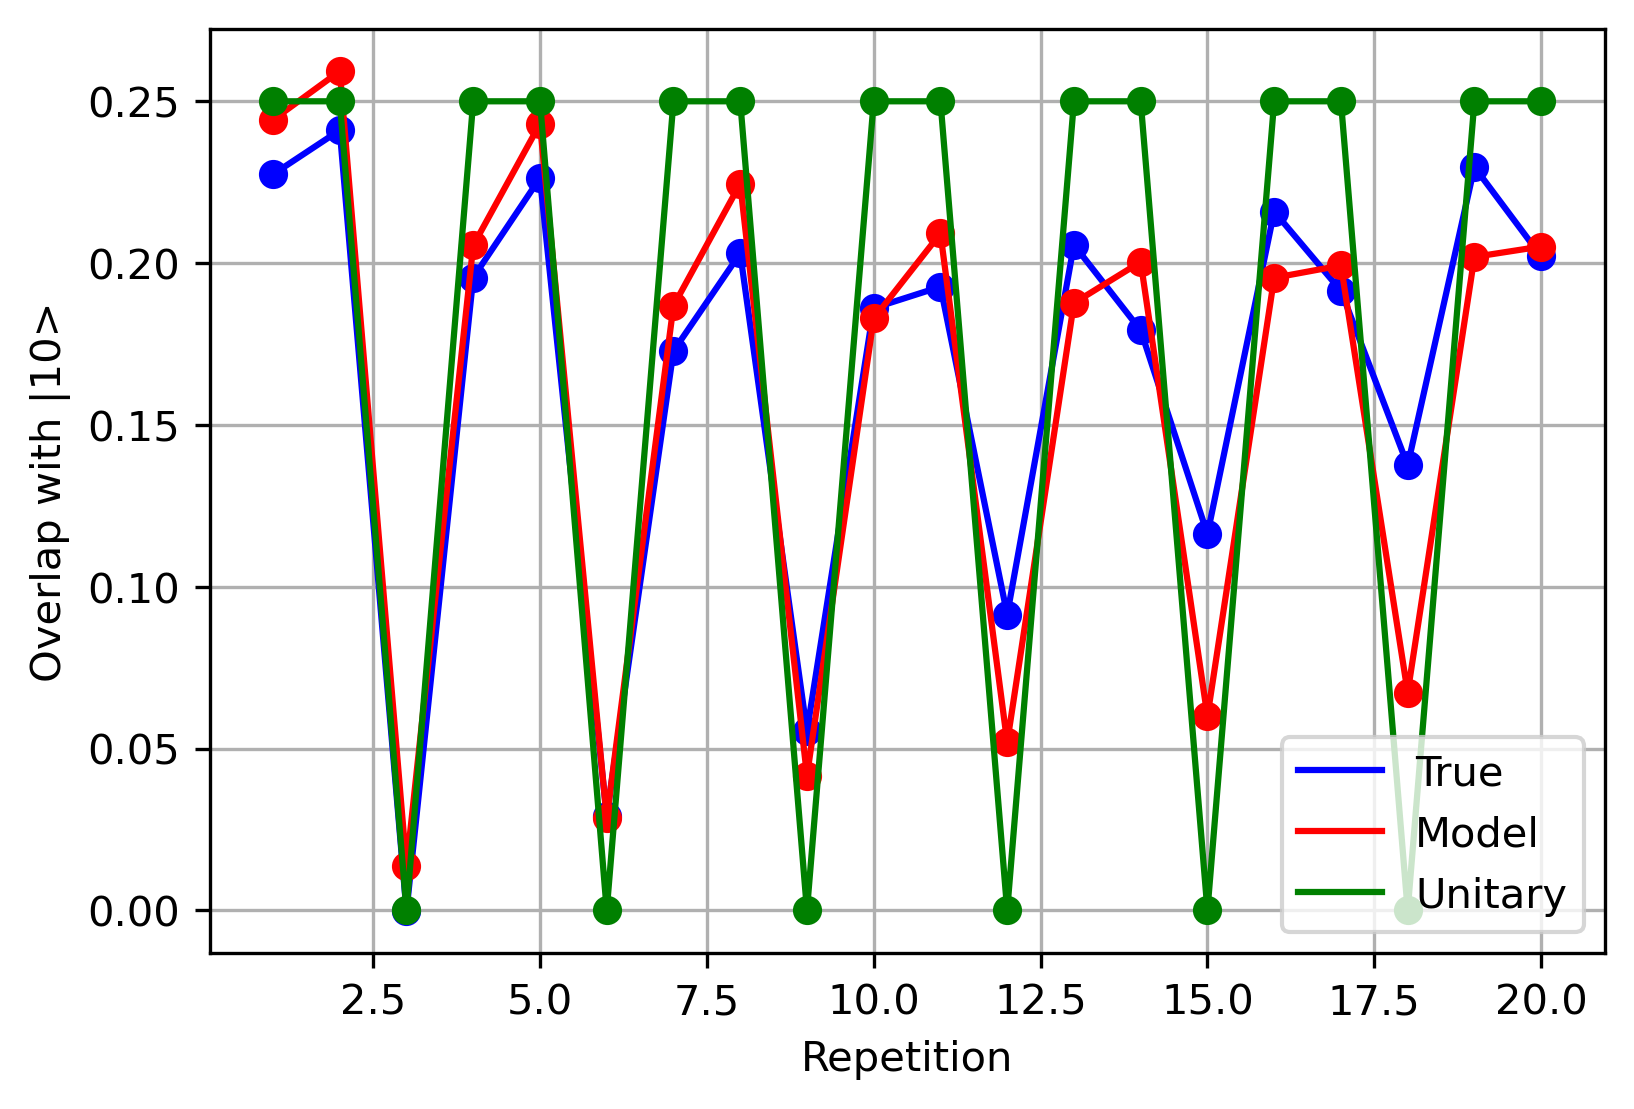

In [80]:
target_test = []
for counts in counts_list[324:-32]:
    vec = counts_to_vector(counts, 2)
    vec = corr_mat@vec
    counts = vector_to_counts(vec, 2)
    target_test.append(counts["10"])
    
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
model_expectation_list = []
unitary_expectation_list = []

for i in range(20):
    state_model = model.map_best.apply_map(state_model)
    model_expectation_list.append(expectation_value(state_model, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(state_unitary, observ))
    
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |10>")
plt.legend()
plt.grid()
plt.show()

In [104]:
n = 2
d = 2**n
rank = 8

np.random.seed(42)
random.seed(42)

circuit = qk.QuantumCircuit(n)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
circuit.h(0)
circuit.s(1)
circuit.cnot(0,1)
U = Operator(circuit).data

kraus_model = KrausMap(d=d, rank=rank)

model = ModelQuantumMap(q_map = kraus_model,
                         cost = expectation_value_loss,
                         input_list = input_list,
                         target_list = target_list,
                         input_val_list = input_list,
                         target_val_list = target_list,
                         lr = 0.05, 
                         h = 1e-3)

In [105]:
model.train(num_iter = 500, 
            use_adam = True,
            N = 100)

  0%|          | 0/500 [00:00<?, ?it/s]

0: fid: 0.22678, c: 0.500
1: fid: 0.21641, c: 0.500
2: fid: 0.20641, c: 0.500
3: fid: 0.19647, c: 0.500
4: fid: 0.18669, c: 0.500
5: fid: 0.17684, c: 0.500
6: fid: 0.16720, c: 0.500
7: fid: 0.15784, c: 0.500
8: fid: 0.14888, c: 0.500
9: fid: 0.14026, c: 0.500
10: fid: 0.13189, c: 0.500
11: fid: 0.12394, c: 0.500
12: fid: 0.11639, c: 0.500
13: fid: 0.10902, c: 0.500
14: fid: 0.10214, c: 0.500
15: fid: 0.09561, c: 0.500
16: fid: 0.08949, c: 0.500
17: fid: 0.08364, c: 0.500
18: fid: 0.07810, c: 0.500
19: fid: 0.07297, c: 0.500
20: fid: 0.06816, c: 0.500
21: fid: 0.06353, c: 0.500
22: fid: 0.05912, c: 0.500
23: fid: 0.05477, c: 0.500
24: fid: 0.05066, c: 0.500
25: fid: 0.04670, c: 0.500
26: fid: 0.04293, c: 0.500
27: fid: 0.03946, c: 0.500
28: fid: 0.03618, c: 0.500
29: fid: 0.03314, c: 0.500
30: fid: 0.03036, c: 0.500
31: fid: 0.02782, c: 0.500
32: fid: 0.02546, c: 0.500
33: fid: 0.02333, c: 0.500
34: fid: 0.02140, c: 0.500
35: fid: 0.01964, c: 0.500
36: fid: 0.01802, c: 0.500
37: fid: 0.

KeyboardInterrupt: 

/home/kristian/anaconda3/envs/env_qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


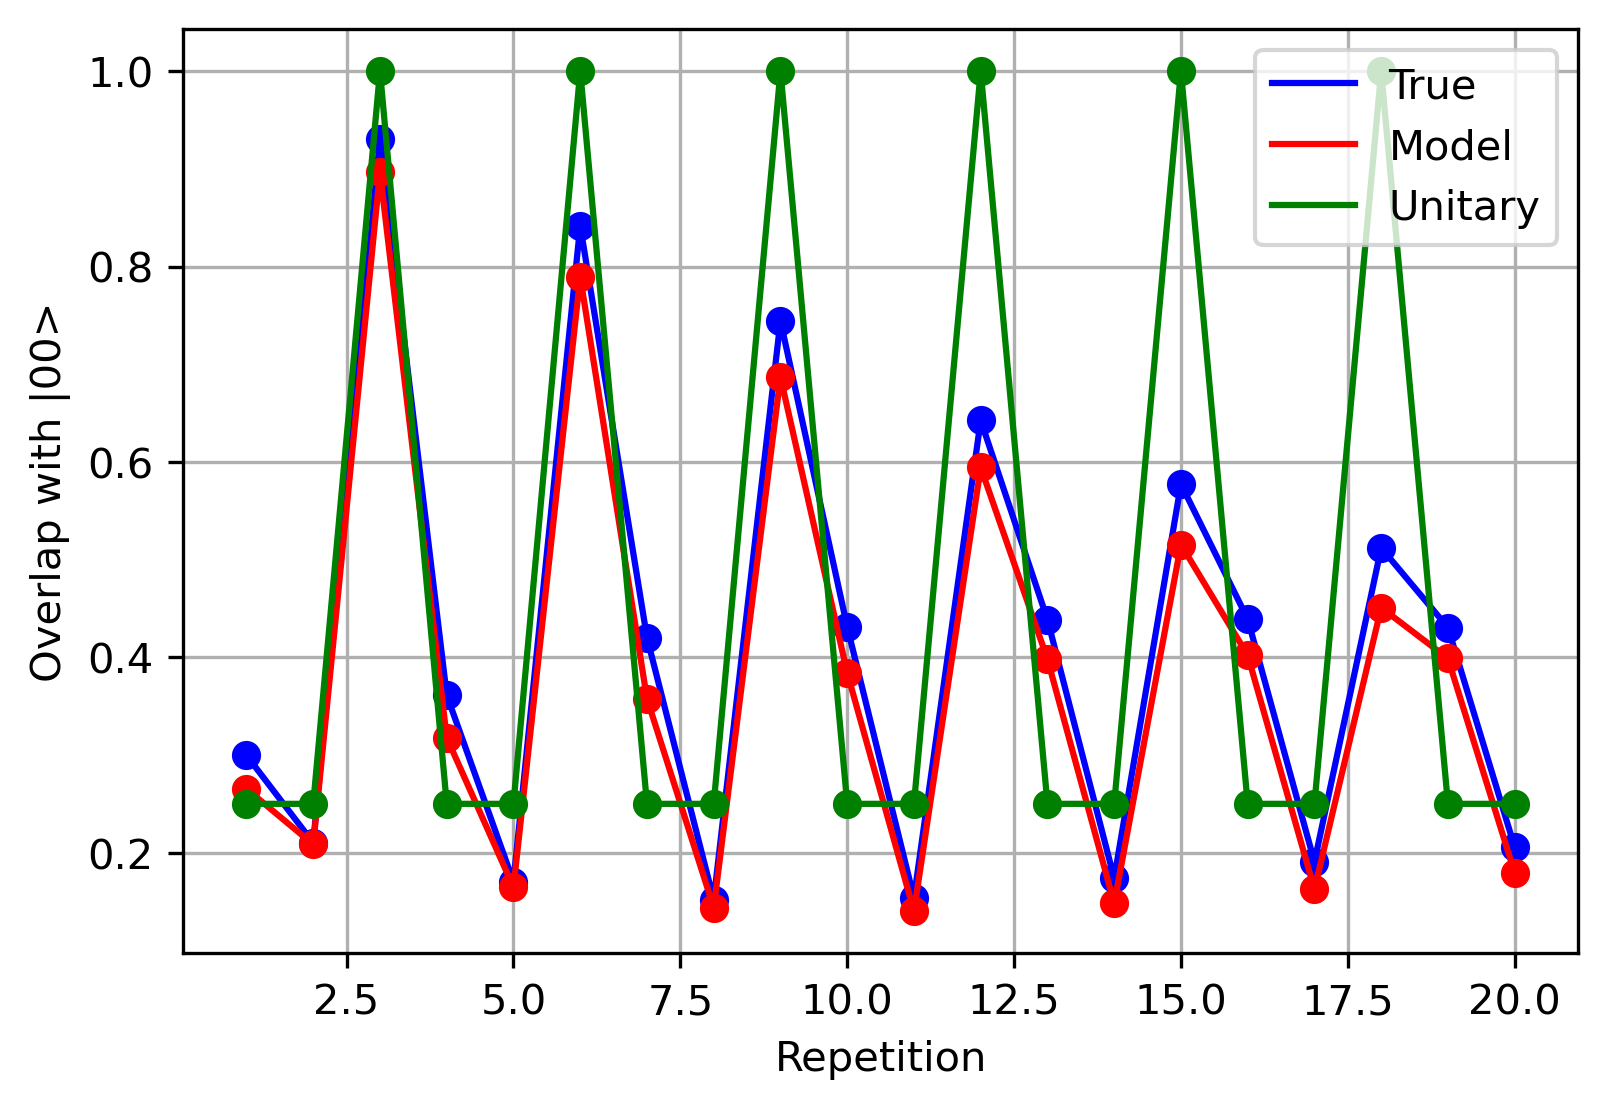

In [108]:
target_test = []
for counts in counts_list[324:-32]:
    vec = counts_to_vector(counts, 2)
    vec = corr_mat@vec
    counts = vector_to_counts(vec, 2)
    target_test.append(counts["00"])
    
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
model_expectation_list = []
unitary_expectation_list = []

for i in range(20):
    state_model = model.map_best.apply_map(state_model)
    model_expectation_list.append(expectation_value(state_model, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(state_unitary, observ))
    
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

## Two Qubit POVM

In [21]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_POVM_trace.p", "rb"))
counts_error = counts_list[-16:]
corr_mat = sum([generate_corruption_matrix(counts_error[4*i:4*(i+1)]) for i in range(4)])/4
print(corr_mat)

povm = corr_mat_to_povm(corr_mat)
#povm = corr_mat_to_povm(np.eye(d))
print(sum(povm))

[[9.332125e-01 3.355000e-02 3.530000e-02 1.362500e-03]
 [4.703750e-02 9.498125e-01 1.962500e-03 3.787500e-02]
 [1.887500e-02 7.000000e-04 9.173250e-01 3.641250e-02]
 [8.750000e-04 1.593750e-02 4.541250e-02 9.243500e-01]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [22]:
target_list = []

for i in range(500-20-16):
    observable = input_list[i][2]
    counts = counts_list[i]
    target_list.append(expectation_value(counts_to_probs(counts), observable))

In [23]:
n = 2
d = 2**n
rank = 3

circuit_target = qk.QuantumCircuit(n)
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
circuit_target.barrier()
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
circuit_target.barrier()
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
circuit_target.barrier()
circuit_target.h(0)
circuit_target.s(1)
circuit_target.cnot(0,1)
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
                       U = U,
                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        lr = 0.05, 
                        h = 1e-3
                        )

In [ ]:
model.train(num_iter = 500,
            use_adam = True,
            N = 20
            )

  0%|          | 0/500 [00:00<?, ?it/s]

0: fid: 0.07432, c: 0.895
1: fid: 0.07404, c: 0.894
2: fid: 0.07380, c: 0.892
3: fid: 0.07352, c: 0.890
4: fid: 0.07313, c: 0.887
5: fid: 0.07265, c: 0.883
6: fid: 0.07215, c: 0.878
7: fid: 0.07170, c: 0.874
8: fid: 0.07124, c: 0.869
9: fid: 0.07084, c: 0.865
10: fid: 0.07041, c: 0.860
11: fid: 0.06999, c: 0.855
12: fid: 0.06949, c: 0.850
13: fid: 0.06895, c: 0.845
14: fid: 0.06839, c: 0.839
15: fid: 0.06791, c: 0.835
16: fid: 0.06751, c: 0.831
17: fid: 0.06708, c: 0.826
18: fid: 0.06668, c: 0.821
19: fid: 0.06628, c: 0.817
20: fid: 0.06588, c: 0.812
21: fid: 0.06545, c: 0.806
22: fid: 0.06509, c: 0.801
23: fid: 0.06473, c: 0.796
24: fid: 0.06432, c: 0.789
25: fid: 0.06395, c: 0.783
26: fid: 0.06364, c: 0.777
27: fid: 0.06334, c: 0.772
28: fid: 0.06302, c: 0.765
29: fid: 0.06259, c: 0.758
30: fid: 0.06218, c: 0.750
31: fid: 0.06183, c: 0.743
32: fid: 0.06149, c: 0.736
33: fid: 0.06118, c: 0.729
34: fid: 0.06094, c: 0.723
35: fid: 0.06071, c: 0.717
36: fid: 0.06052, c: 0.710
37: fid: 0.

In [18]:
state_unitary = state_model = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
observ = np.zeros(2**n)
observ[0] = 1
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[500-20-16:-16]]


for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    model_expectation_list.append(expectation_value(measurement(state_model, povm=model.q_map.povm), observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    #unitary_expectation_list.append(expectation_value(state_unitary, observ))
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

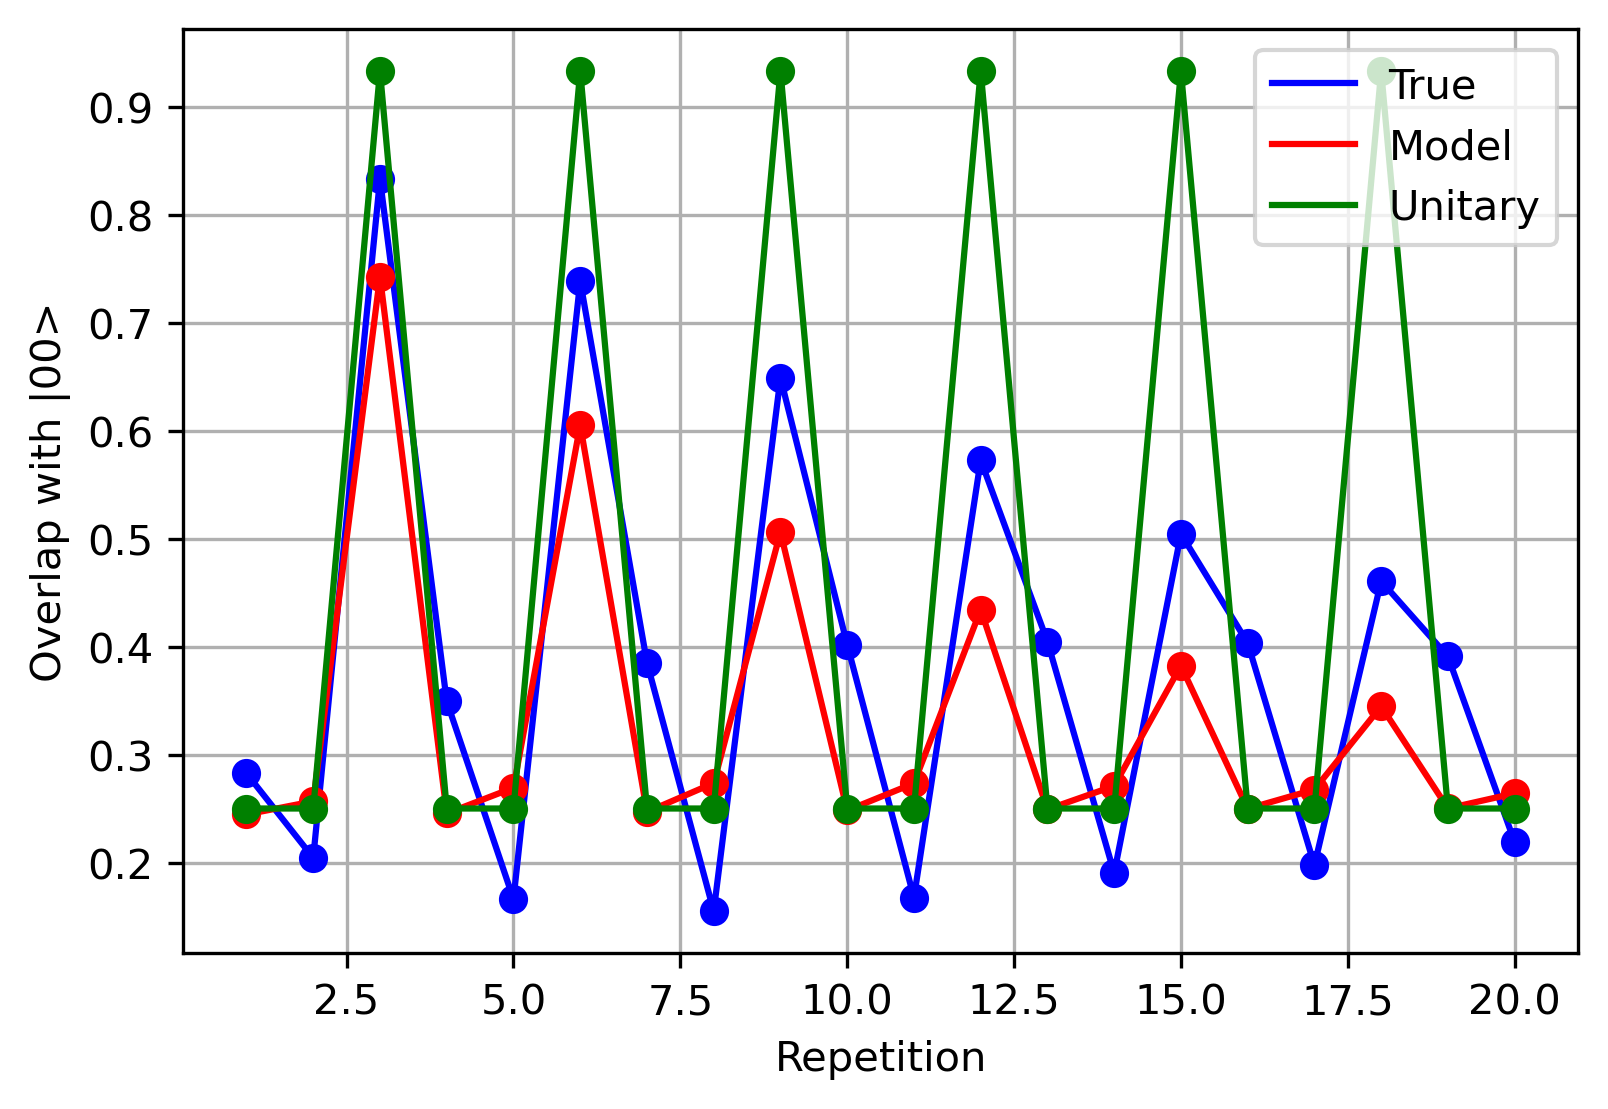

In [19]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")
plt.legend()
plt.grid()
plt.show()

In [53]:
print(parity_observable(3, trace_index_list=[]))
print(parity_observable(3, trace_index_list=[1]))

[ 1 -1 -1  1 -1  1  1 -1]
[ 1. -1.  1. -1. -1.  1. -1.  1.]


## Three Qubit QFT

In [2]:
n = 3
input_list, counts_list = pickle.load(open("..\..\data\threeQubits_expectation_qft_error.p", "rb"))

counts_error = counts_list[-64:]
corr_mat = sum([generate_corruption_matrix(counts_error[8*i:8*(i+1)]) for i in range(8)])/8
corr_mat = np.linalg.inv(corr_mat)
print(corr_mat)

TypeError: generate_corruption_matrix() takes 1 positional argument but 2 were given

In [85]:
target_list = []
for counts in counts_list[:500-64]:
    vec = counts_to_vector(counts, 3)
    vec = corr_mat@vec
    counts = vector_to_counts(vec, 3)
    target_list.append(expected_parity(counts))

In [87]:
def qft(n):
    circuit = qk.QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.cp(2*np.pi/2**(j-i+1), j, i)
            
    return circuit

In [95]:
n = 3
d = 2**n
rank = 9

np.random.seed(42)
random.seed(42)

circuit = qft(n)
U = Operator(circuit).data

kraus_model = KrausMap(U=U, c = 0.9, d=d, rank=rank)

model = ModelQuantumMap(q_map = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        lr = 0.05, 
                        h = 1e-3)

In [96]:
model.train(num_iter = 1000, 
            use_adam = True,
            N = 50)

  0%|          | 0/1000 [00:00<?, ?it/s]

0: fid: 0.01353, c: 0.895
1: fid: 0.01324, c: 0.891
2: fid: 0.01293, c: 0.886
3: fid: 0.01264, c: 0.881
4: fid: 0.01234, c: 0.875
5: fid: 0.01203, c: 0.870
6: fid: 0.01171, c: 0.864
7: fid: 0.01142, c: 0.858
8: fid: 0.01110, c: 0.852
9: fid: 0.01079, c: 0.846
10: fid: 0.01049, c: 0.840
11: fid: 0.01017, c: 0.833
12: fid: 0.00985, c: 0.826
13: fid: 0.00953, c: 0.820
14: fid: 0.00922, c: 0.813
15: fid: 0.00892, c: 0.805
16: fid: 0.00862, c: 0.798
17: fid: 0.00831, c: 0.789
18: fid: 0.00801, c: 0.782
19: fid: 0.00774, c: 0.774
20: fid: 0.00748, c: 0.766
21: fid: 0.00724, c: 0.758
22: fid: 0.00700, c: 0.751
23: fid: 0.00679, c: 0.743
24: fid: 0.00657, c: 0.734
25: fid: 0.00639, c: 0.727
26: fid: 0.00623, c: 0.720
27: fid: 0.00609, c: 0.714
28: fid: 0.00596, c: 0.708
29: fid: 0.00583, c: 0.702
30: fid: 0.00572, c: 0.697
31: fid: 0.00561, c: 0.692
32: fid: 0.00552, c: 0.688
33: fid: 0.00542, c: 0.684
34: fid: 0.00533, c: 0.680
35: fid: 0.00523, c: 0.677
36: fid: 0.00514, c: 0.675
37: fid: 0.

297: fid: 0.00078, c: 0.468
298: fid: 0.00079, c: 0.467
299: fid: 0.00079, c: 0.466
300: fid: 0.00079, c: 0.465
301: fid: 0.00079, c: 0.464
302: fid: 0.00079, c: 0.464
303: fid: 0.00078, c: 0.464
304: fid: 0.00078, c: 0.465
305: fid: 0.00077, c: 0.466
306: fid: 0.00076, c: 0.466
307: fid: 0.00075, c: 0.467
308: fid: 0.00074, c: 0.468
309: fid: 0.00074, c: 0.469
310: fid: 0.00073, c: 0.470
311: fid: 0.00073, c: 0.471
312: fid: 0.00072, c: 0.472
313: fid: 0.00072, c: 0.473
314: fid: 0.00072, c: 0.473
315: fid: 0.00071, c: 0.475
316: fid: 0.00071, c: 0.477
317: fid: 0.00072, c: 0.478
318: fid: 0.00071, c: 0.478
319: fid: 0.00071, c: 0.479
320: fid: 0.00071, c: 0.479
321: fid: 0.00071, c: 0.478
322: fid: 0.00071, c: 0.477
323: fid: 0.00070, c: 0.475
324: fid: 0.00070, c: 0.473
325: fid: 0.00070, c: 0.472
326: fid: 0.00069, c: 0.471
327: fid: 0.00068, c: 0.471
328: fid: 0.00068, c: 0.472
329: fid: 0.00067, c: 0.473
330: fid: 0.00067, c: 0.474
331: fid: 0.00066, c: 0.475
332: fid: 0.00066, c

590: fid: 0.00038, c: 0.359
591: fid: 0.00038, c: 0.358
592: fid: 0.00038, c: 0.356
593: fid: 0.00038, c: 0.355
594: fid: 0.00039, c: 0.354
595: fid: 0.00039, c: 0.354
596: fid: 0.00039, c: 0.354
597: fid: 0.00039, c: 0.355
598: fid: 0.00039, c: 0.356
599: fid: 0.00038, c: 0.357
600: fid: 0.00038, c: 0.359
601: fid: 0.00038, c: 0.360
602: fid: 0.00038, c: 0.360
603: fid: 0.00039, c: 0.360
604: fid: 0.00039, c: 0.360
605: fid: 0.00039, c: 0.360
606: fid: 0.00040, c: 0.360
607: fid: 0.00040, c: 0.360
608: fid: 0.00040, c: 0.359
609: fid: 0.00039, c: 0.358
610: fid: 0.00039, c: 0.356
611: fid: 0.00038, c: 0.354
612: fid: 0.00038, c: 0.353
613: fid: 0.00038, c: 0.351
614: fid: 0.00037, c: 0.350
615: fid: 0.00037, c: 0.348
616: fid: 0.00037, c: 0.347
617: fid: 0.00037, c: 0.346
618: fid: 0.00037, c: 0.346
619: fid: 0.00036, c: 0.345
620: fid: 0.00036, c: 0.345
621: fid: 0.00036, c: 0.345
622: fid: 0.00036, c: 0.346
623: fid: 0.00036, c: 0.346
624: fid: 0.00036, c: 0.347
625: fid: 0.00036, c

883: fid: 0.00024, c: 0.271
884: fid: 0.00024, c: 0.271
885: fid: 0.00024, c: 0.271
886: fid: 0.00024, c: 0.271
887: fid: 0.00024, c: 0.270
888: fid: 0.00024, c: 0.270
889: fid: 0.00024, c: 0.269
890: fid: 0.00025, c: 0.269
891: fid: 0.00025, c: 0.269
892: fid: 0.00025, c: 0.268
893: fid: 0.00025, c: 0.268
894: fid: 0.00025, c: 0.267
895: fid: 0.00025, c: 0.267
896: fid: 0.00024, c: 0.268
897: fid: 0.00024, c: 0.267
898: fid: 0.00024, c: 0.267
899: fid: 0.00024, c: 0.267
900: fid: 0.00024, c: 0.266
901: fid: 0.00024, c: 0.265
902: fid: 0.00024, c: 0.265
903: fid: 0.00023, c: 0.265
904: fid: 0.00023, c: 0.264
905: fid: 0.00023, c: 0.264
906: fid: 0.00023, c: 0.264
907: fid: 0.00023, c: 0.264
908: fid: 0.00024, c: 0.264
909: fid: 0.00024, c: 0.263
910: fid: 0.00024, c: 0.263
911: fid: 0.00025, c: 0.263
912: fid: 0.00025, c: 0.263
913: fid: 0.00026, c: 0.264
914: fid: 0.00026, c: 0.264
915: fid: 0.00026, c: 0.264
916: fid: 0.00025, c: 0.264
917: fid: 0.00025, c: 0.264
918: fid: 0.00024, c

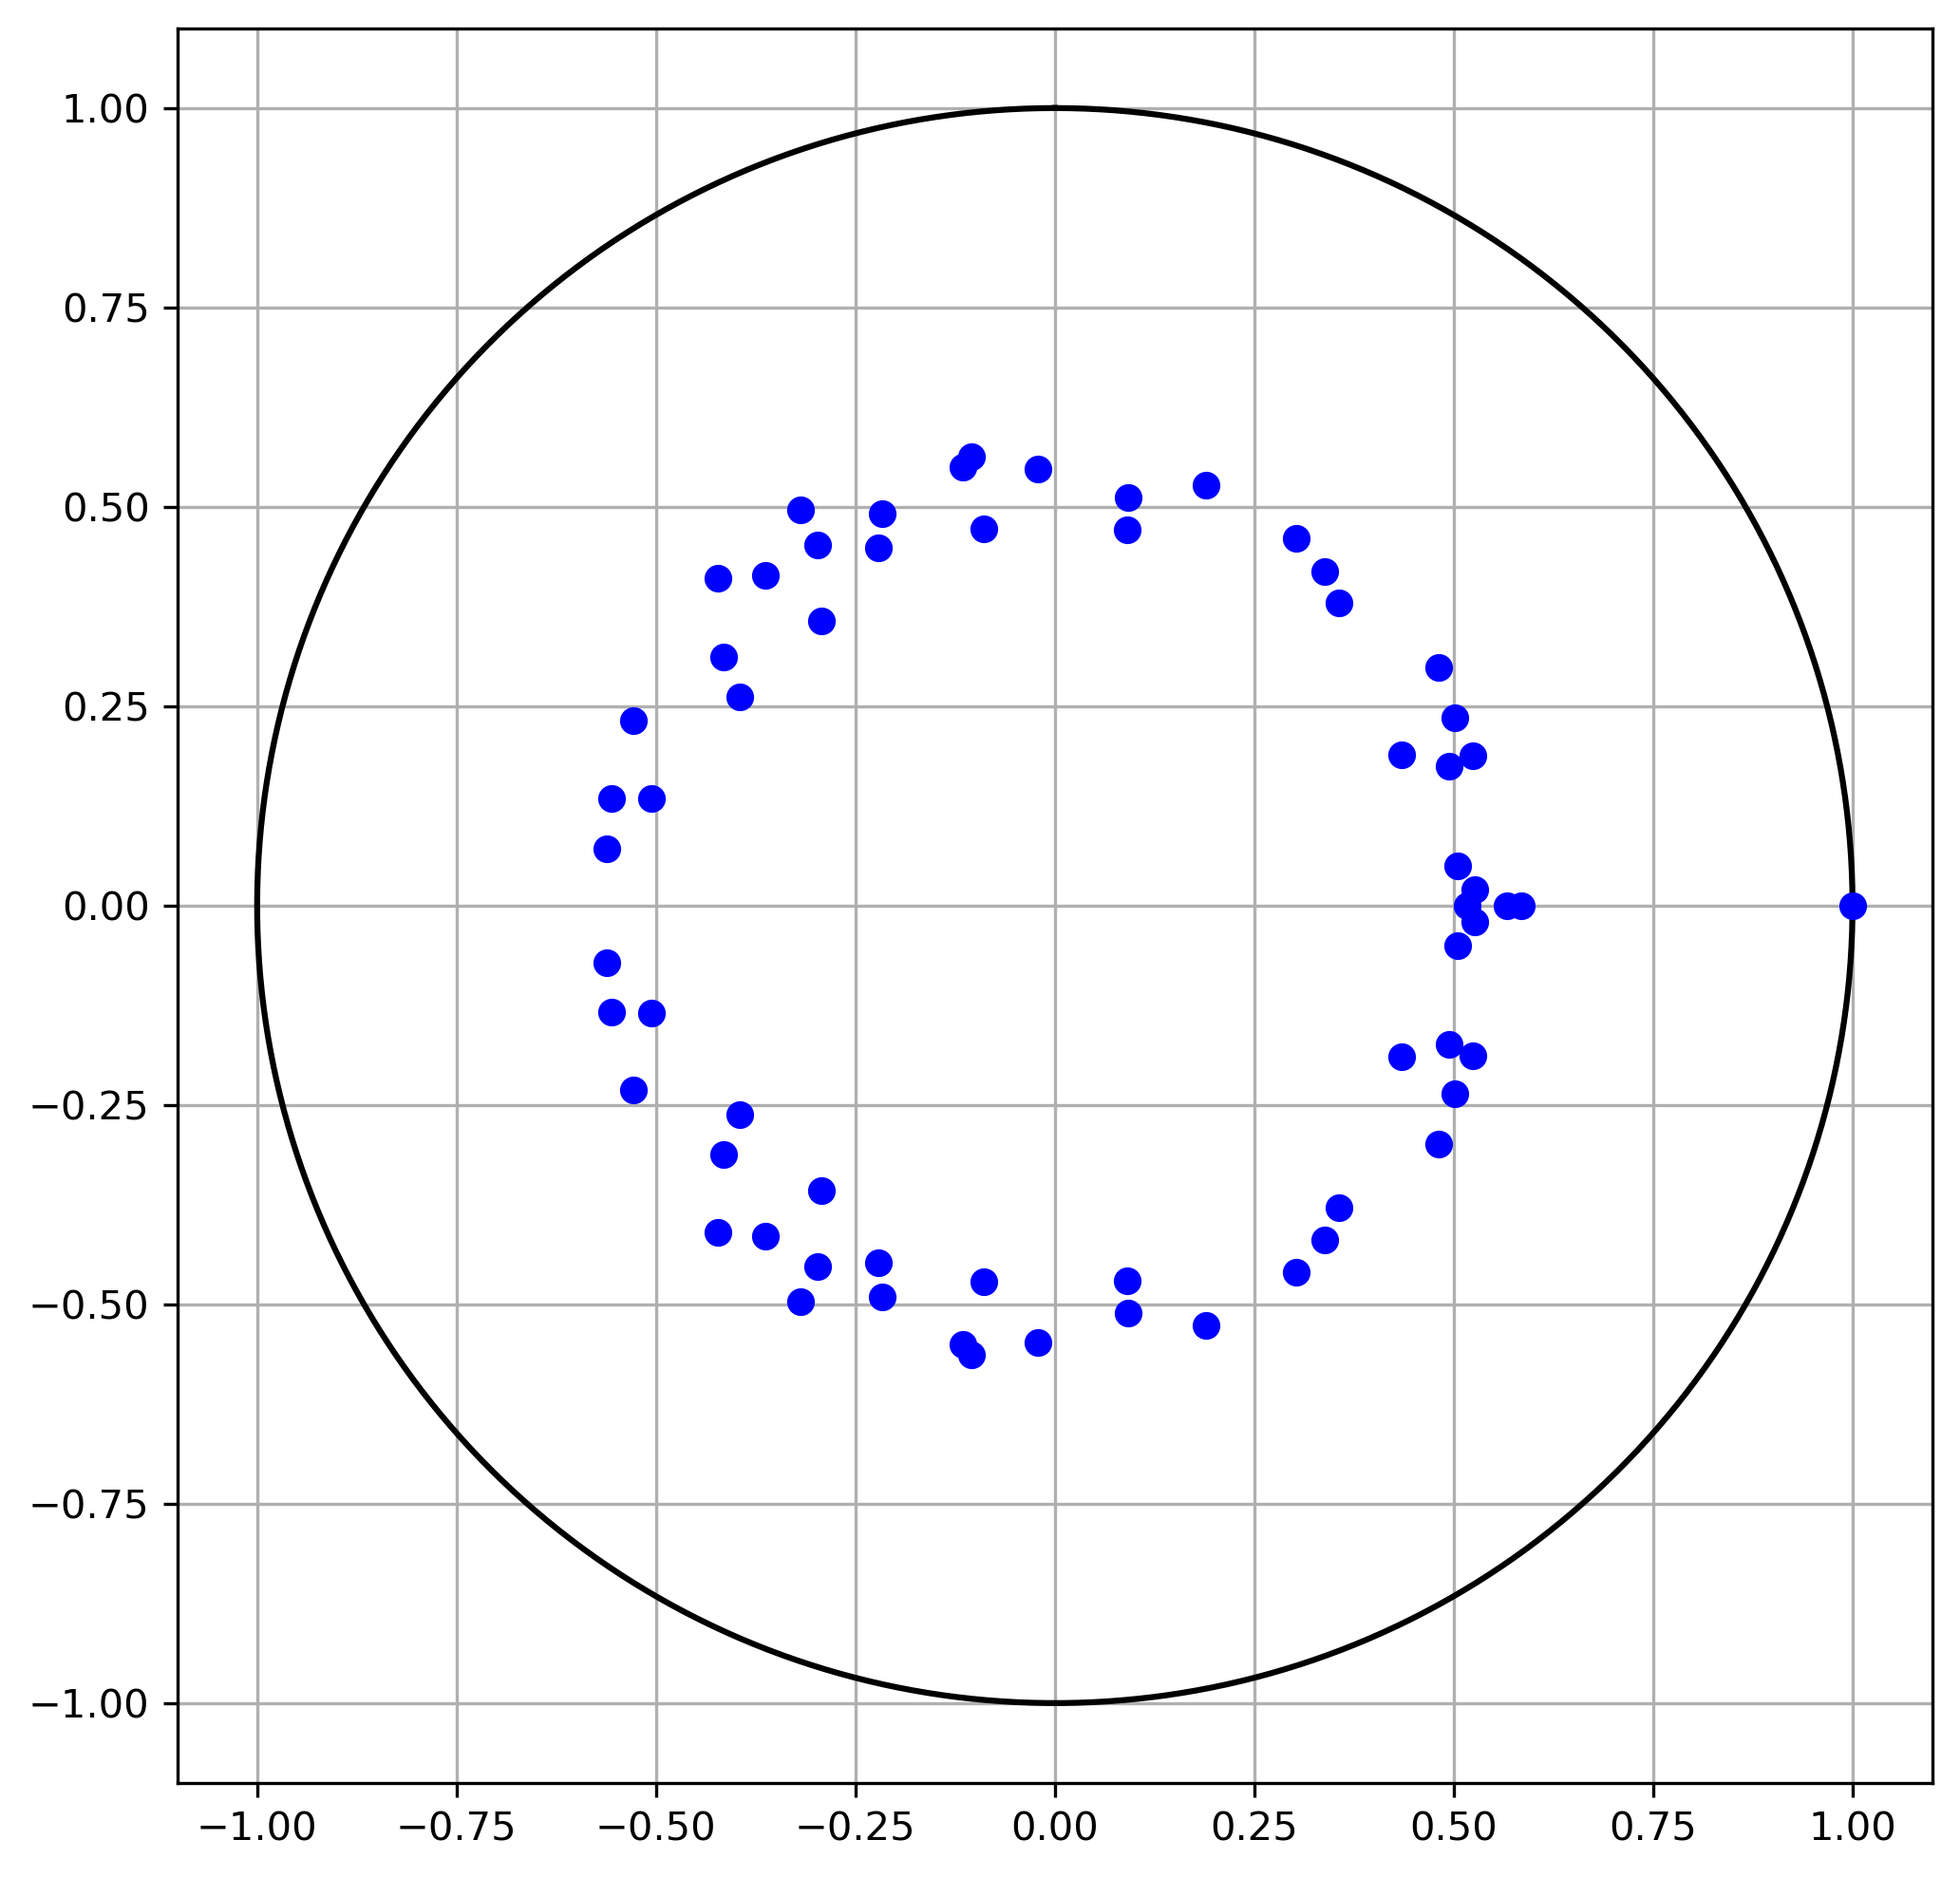

In [107]:

t = np.linspace(0, 2*np.pi, 1000)

circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
#choi = maps_to_choi([model.q_map])
#spectrum = choi_spectrum(choi)
plt.plot(*circle, "k-")
plt.plot(*spectrum, "bo")
plt.grid()
plt.show()

### Force Unitary

In [2]:
n = 3
input_list, counts_list = pickle.load(open("..\..\data\threeQubits_expectation_qft_error.p", "rb"))

counts_error = counts_list[-64:]
corr_mat = sum([generate_corruption_matrix(counts_error[8*i:8*(i+1)]) for i in range(8)])/8
print(corr_mat)
corr_mat = np.linalg.inv(corr_mat)

[[9.3798750e-01 2.3756250e-02 2.2568750e-02 5.7500000e-04 1.4450000e-02
  3.1875000e-04 3.4375000e-04 0.0000000e+00]
 [7.5587500e-02 8.9003125e-01 1.5500000e-03 1.9712500e-02 1.0187500e-03
  1.1812500e-02 1.2500000e-05 2.7500000e-04]
 [4.0637500e-02 1.0562500e-03 9.1979375e-01 2.5043750e-02 7.2500000e-04
  6.2500000e-06 1.2381250e-02 3.5625000e-04]
 [3.2437500e-03 3.6993750e-02 7.5081250e-02 8.7090000e-01 3.1250000e-05
  7.1875000e-04 1.1312500e-03 1.1900000e-02]
 [3.5531250e-02 8.8750000e-04 9.0000000e-04 6.2500000e-06 9.1733125e-01
  2.4793750e-02 2.0118750e-02 4.3125000e-04]
 [2.8062500e-03 3.2868750e-02 3.1250000e-05 6.8125000e-04 7.2650000e-02
  8.7228750e-01 1.5062500e-03 1.7168750e-02]
 [1.5437500e-03 5.6250000e-05 3.5250000e-02 1.0437500e-03 4.2900000e-02
  1.1687500e-03 8.9361250e-01 2.4425000e-02]
 [6.8750000e-05 1.3375000e-03 2.9062500e-03 3.3431250e-02 3.3187500e-03
  3.8537500e-02 7.0412500e-02 8.4998750e-01]]


In [3]:
target_list = []
for counts in counts_list[:500-64]:
    vec = counts_to_vector(counts)
    vec = corr_mat@vec
    counts = vector_to_counts(vec)
    target_list.append(expected_parity(counts))

In [5]:
n = 3
d = 2**n
rank = 1

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(d=d, rank=rank)

model = ModelQuantumMap(q_map = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        lr = 0.05, 
                        h = 1e-3)

In [6]:
model.train(num_iter = 1000, 
            use_adam = True,
            N = 50)

  0%|          | 0/1000 [00:00<?, ?it/s]

0: fid: 0.15463, c: 0.500
1: fid: 0.14996, c: 0.500
2: fid: 0.14706, c: 0.500
3: fid: 0.14544, c: 0.500
4: fid: 0.14345, c: 0.500
5: fid: 0.14049, c: 0.500
6: fid: 0.13687, c: 0.500
7: fid: 0.13366, c: 0.500
8: fid: 0.13124, c: 0.500
9: fid: 0.12927, c: 0.500
10: fid: 0.12728, c: 0.500
11: fid: 0.12495, c: 0.500
12: fid: 0.12233, c: 0.500
13: fid: 0.12013, c: 0.500
14: fid: 0.11807, c: 0.500
15: fid: 0.11629, c: 0.500
16: fid: 0.11466, c: 0.500
17: fid: 0.11389, c: 0.500
18: fid: 0.11317, c: 0.500
19: fid: 0.11253, c: 0.500
20: fid: 0.11158, c: 0.500
21: fid: 0.11076, c: 0.500
22: fid: 0.11012, c: 0.500
23: fid: 0.10956, c: 0.500
24: fid: 0.10907, c: 0.500
25: fid: 0.10862, c: 0.500
26: fid: 0.10799, c: 0.500
27: fid: 0.10725, c: 0.500
28: fid: 0.10652, c: 0.500
29: fid: 0.10579, c: 0.500
30: fid: 0.10504, c: 0.500
31: fid: 0.10437, c: 0.500
32: fid: 0.10373, c: 0.500
33: fid: 0.10326, c: 0.500
34: fid: 0.10265, c: 0.500
35: fid: 0.10212, c: 0.500
36: fid: 0.10145, c: 0.500
37: fid: 0.

297: fid: 0.06670, c: 0.500
298: fid: 0.06649, c: 0.500
299: fid: 0.06604, c: 0.500
300: fid: 0.06571, c: 0.500
301: fid: 0.06533, c: 0.500
302: fid: 0.06516, c: 0.500
303: fid: 0.06499, c: 0.500
304: fid: 0.06488, c: 0.500
305: fid: 0.06476, c: 0.500
306: fid: 0.06472, c: 0.500
307: fid: 0.06479, c: 0.500
308: fid: 0.06499, c: 0.500
309: fid: 0.06509, c: 0.500
310: fid: 0.06525, c: 0.500
311: fid: 0.06530, c: 0.500
312: fid: 0.06529, c: 0.500
313: fid: 0.06529, c: 0.500
314: fid: 0.06525, c: 0.500
315: fid: 0.06514, c: 0.500
316: fid: 0.06502, c: 0.500
317: fid: 0.06490, c: 0.500
318: fid: 0.06475, c: 0.500
319: fid: 0.06459, c: 0.500
320: fid: 0.06448, c: 0.500
321: fid: 0.06436, c: 0.500
322: fid: 0.06426, c: 0.500
323: fid: 0.06421, c: 0.500
324: fid: 0.06409, c: 0.500
325: fid: 0.06400, c: 0.500
326: fid: 0.06409, c: 0.500
327: fid: 0.06427, c: 0.500
328: fid: 0.06438, c: 0.500
329: fid: 0.06450, c: 0.500
330: fid: 0.06443, c: 0.500
331: fid: 0.06438, c: 0.500
332: fid: 0.06438, c

590: fid: 0.05927, c: 0.500
591: fid: 0.05920, c: 0.500
592: fid: 0.05912, c: 0.500
593: fid: 0.05909, c: 0.500
594: fid: 0.05912, c: 0.500
595: fid: 0.05915, c: 0.500
596: fid: 0.05916, c: 0.500
597: fid: 0.05921, c: 0.500
598: fid: 0.05928, c: 0.500
599: fid: 0.05935, c: 0.500
600: fid: 0.05937, c: 0.500
601: fid: 0.05939, c: 0.500
602: fid: 0.05940, c: 0.500
603: fid: 0.05939, c: 0.500
604: fid: 0.05939, c: 0.500
605: fid: 0.05941, c: 0.500
606: fid: 0.05945, c: 0.500
607: fid: 0.05950, c: 0.500
608: fid: 0.05952, c: 0.500
609: fid: 0.05952, c: 0.500
610: fid: 0.05952, c: 0.500
611: fid: 0.05953, c: 0.500
612: fid: 0.05951, c: 0.500
613: fid: 0.05950, c: 0.500
614: fid: 0.05944, c: 0.500
615: fid: 0.05937, c: 0.500
616: fid: 0.05930, c: 0.500
617: fid: 0.05921, c: 0.500
618: fid: 0.05919, c: 0.500
619: fid: 0.05915, c: 0.500
620: fid: 0.05913, c: 0.500
621: fid: 0.05914, c: 0.500
622: fid: 0.05919, c: 0.500
623: fid: 0.05927, c: 0.500
624: fid: 0.05935, c: 0.500
625: fid: 0.05941, c

883: fid: 0.05807, c: 0.500
884: fid: 0.05812, c: 0.500
885: fid: 0.05820, c: 0.500
886: fid: 0.05828, c: 0.500
887: fid: 0.05839, c: 0.500
888: fid: 0.05849, c: 0.500
889: fid: 0.05863, c: 0.500
890: fid: 0.05866, c: 0.500
891: fid: 0.05869, c: 0.500
892: fid: 0.05879, c: 0.500
893: fid: 0.05880, c: 0.500
894: fid: 0.05877, c: 0.500
895: fid: 0.05883, c: 0.500
896: fid: 0.05884, c: 0.500
897: fid: 0.05879, c: 0.500
898: fid: 0.05874, c: 0.500
899: fid: 0.05867, c: 0.500
900: fid: 0.05852, c: 0.500
901: fid: 0.05841, c: 0.500
902: fid: 0.05838, c: 0.500
903: fid: 0.05836, c: 0.500
904: fid: 0.05830, c: 0.500
905: fid: 0.05820, c: 0.500
906: fid: 0.05814, c: 0.500
907: fid: 0.05805, c: 0.500
908: fid: 0.05802, c: 0.500
909: fid: 0.05798, c: 0.500
910: fid: 0.05794, c: 0.500
911: fid: 0.05786, c: 0.500
912: fid: 0.05777, c: 0.500
913: fid: 0.05777, c: 0.500
914: fid: 0.05769, c: 0.500
915: fid: 0.05758, c: 0.500
916: fid: 0.05749, c: 0.500
917: fid: 0.05743, c: 0.500
918: fid: 0.05743, c

In [11]:
def qft(n):
    circuit = qk.QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.cp(2*np.pi/2**(j-i+1), j, i)
            
    return circuit

In [14]:
circuit = qft(n)
U = Operator(circuit).data

kraus_model = KrausMap(U=U, c = 0.9999, d=d, rank=rank)

model2 = ModelQuantumMap(q_map = kraus_model,
                        cost = expectation_value_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        lr = 0.05, 
                        h = 1e-3)

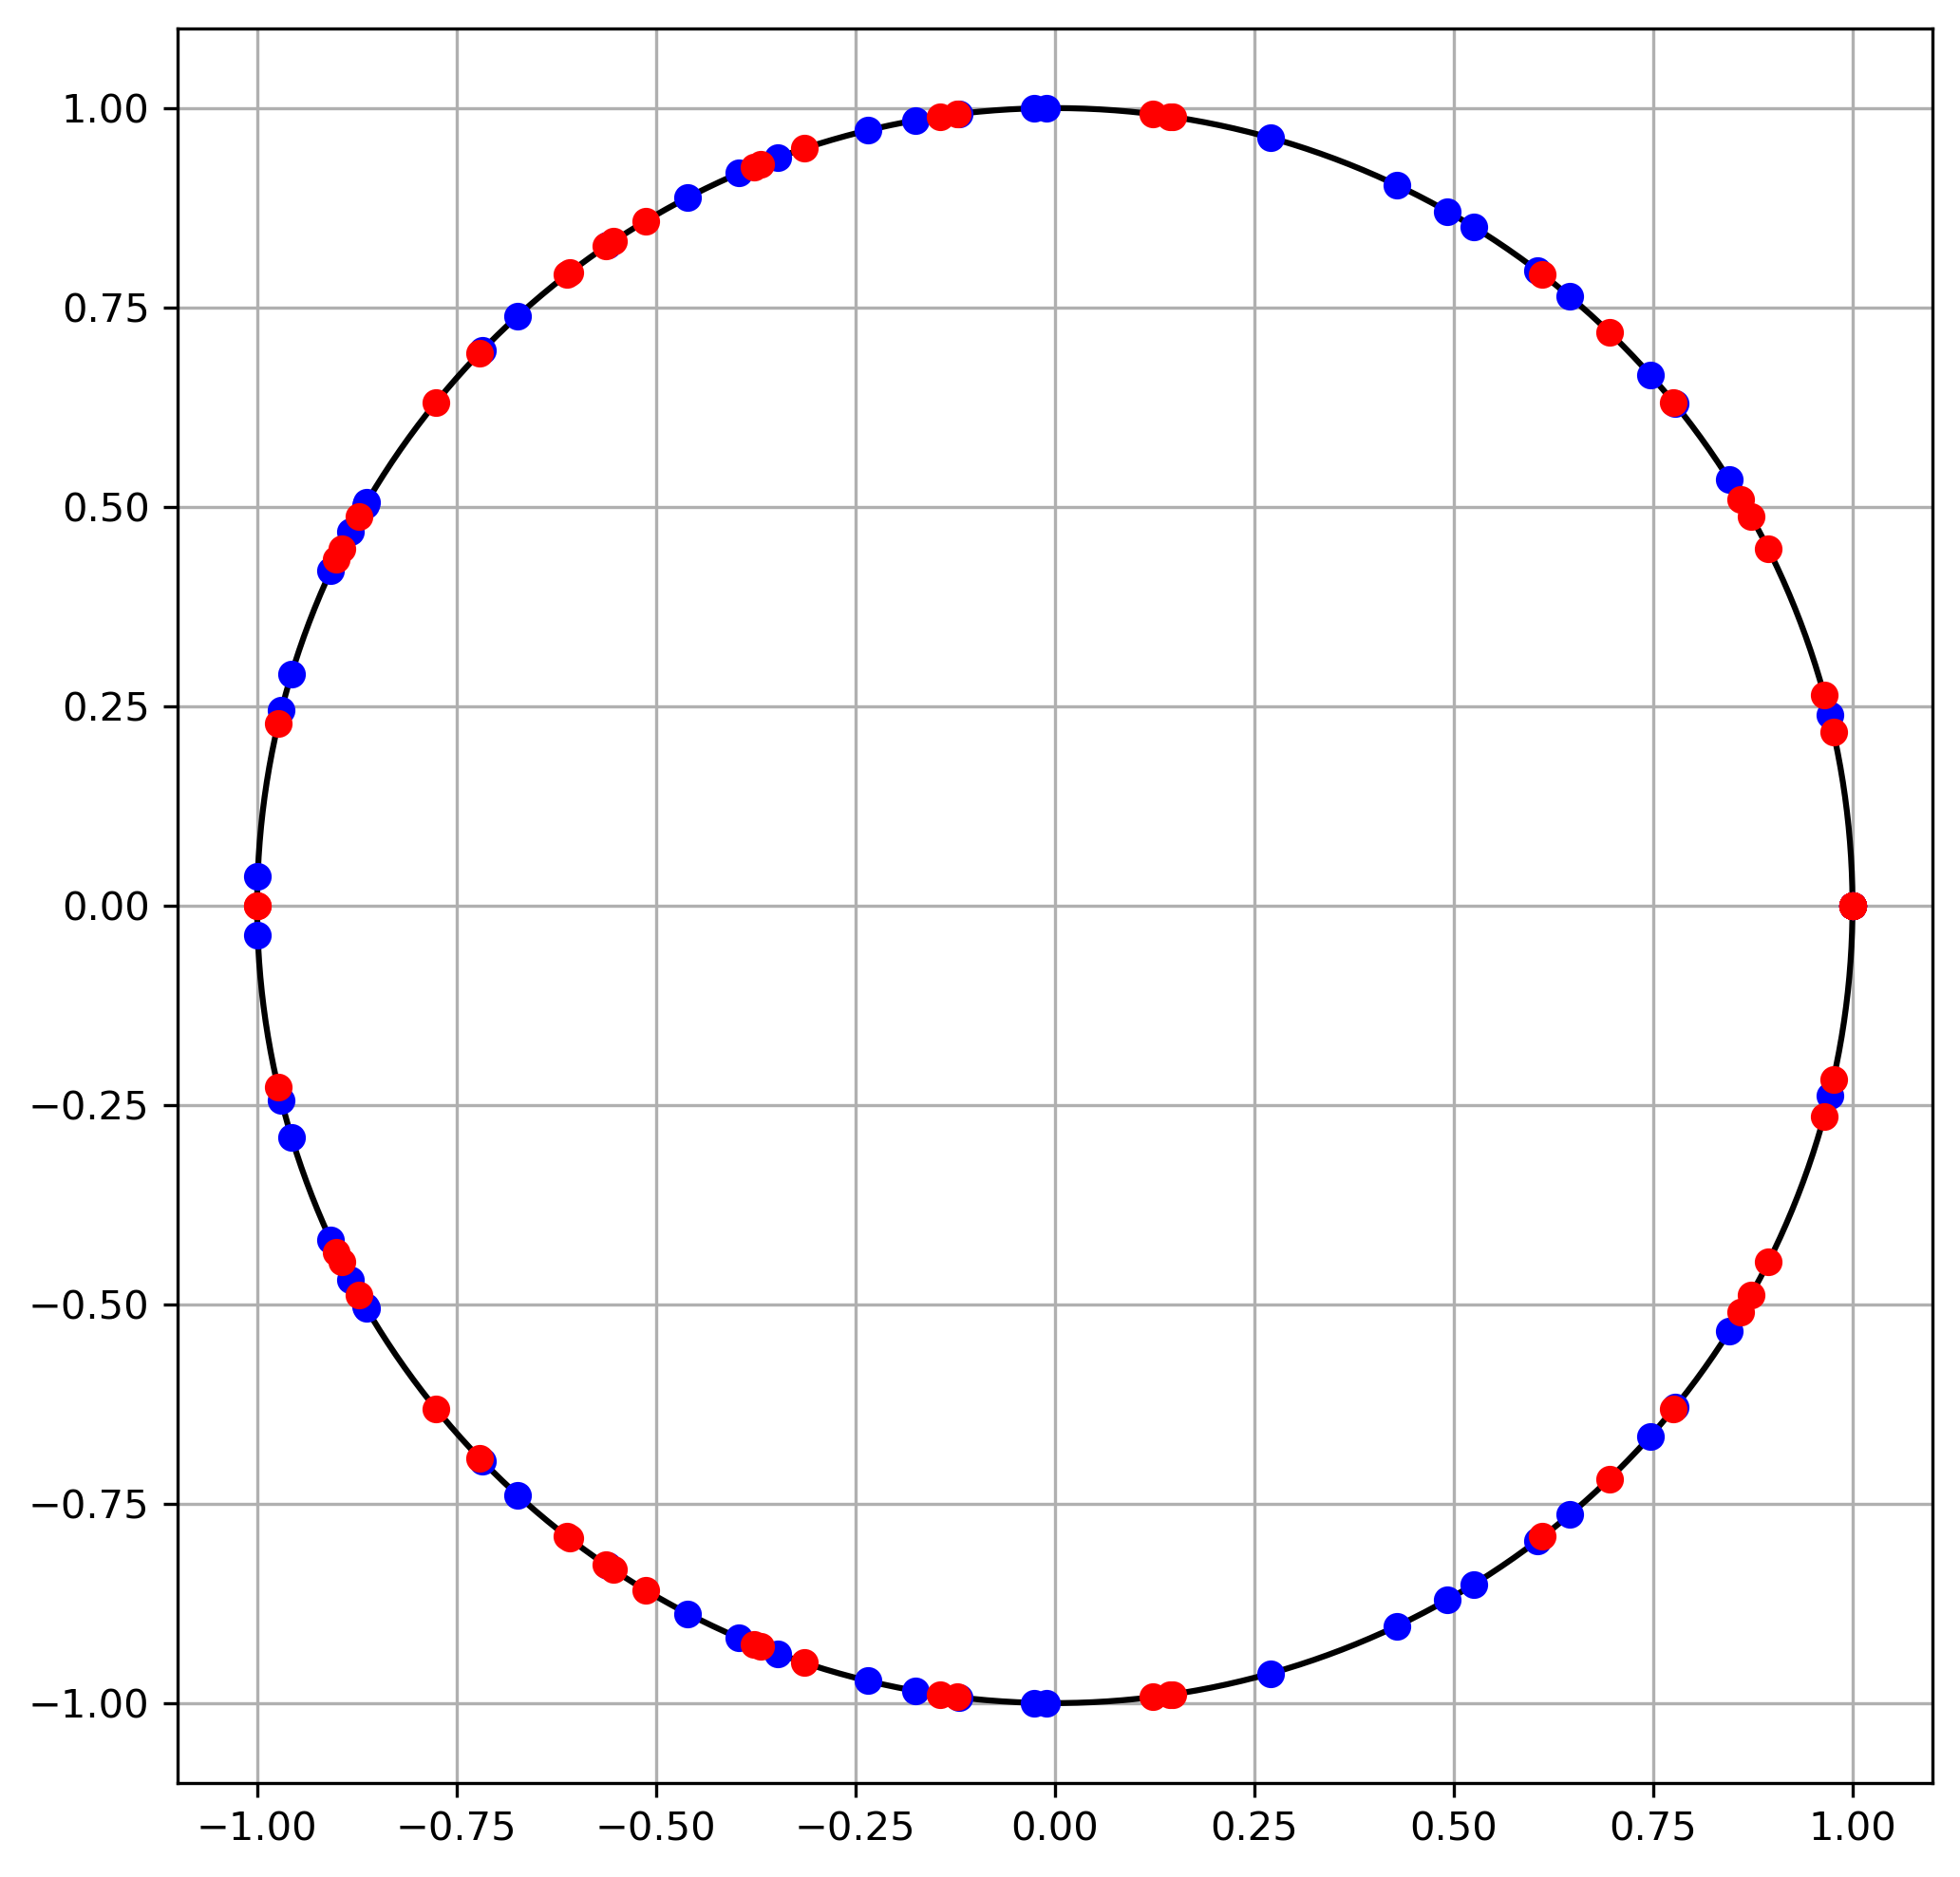

In [15]:
t = np.linspace(0, 2*np.pi, 1000)

circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
choi = maps_to_choi([model.q_map])
spectrum = choi_spectrum(choi)
choi2 = maps_to_choi([model2.q_map])
spectrum2 = choi_spectrum(choi2)
plt.plot(*circle, "k-")
plt.plot(*spectrum, "bo")
plt.plot(*spectrum2, "ro")
plt.grid()
plt.show()

In [19]:
print(channel_fidelity(model.q_map, model2.q_map))

0.06969559089639477


## Two Qubit Variation Blocks

In [22]:
def variational_circuit(n):
    theta = np.random.uniform(-np.pi, np.pi, 4*n)
    circuit = qk.QuantumCircuit(n)
    for i, angle in enumerate(theta[:n]):
        circuit.ry(angle, i)
    
    for i, angle in enumerate(theta[n:2*n]):
        circuit.crx(angle, i, (i+1)%n)
        
    for i, angle in enumerate(theta[2*n:3*n]):
        circuit.ry(angle, i)
        
    for i, angle in enumerate(theta[3*n:]):
        circuit.crx(angle, (n-i)%n, n-i-1)
    
    return circuit

In [23]:
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_variational.p", "rb"))
counts_error = counts_list[-16:]
corr_mat = sum([generate_corruption_matrix(counts_error[4*i:4*(i+1)]) for i in range(4)])/4
print(corr_mat)

povm = corr_mat_to_povm(corr_mat)

[[9.062375e-01 1.385000e-02 8.912500e-03 1.500000e-04]
 [1.792500e-02 9.286625e-01 1.500000e-04 9.362500e-03]
 [7.455000e-02 1.125000e-03 9.702125e-01 1.507500e-02]
 [1.287500e-03 5.636250e-02 2.072500e-02 9.754125e-01]]


In [27]:
target_list1 = [expectation_value(counts_to_probs(counts), input[2]) for input, counts in zip(input_list, counts_list[:161])]
target_list2 = [expectation_value(counts_to_probs(counts), input[2]) for input, counts in zip(input_list, counts_list[161:2*161])]
target_list3 = [expectation_value(counts_to_probs(counts), input[2]) for input, counts in zip(input_list, counts_list[2*161:3*161])]
                
input_list1 = input_list[:161]
input_list2 = input_list[161:(2*161)]
input_list3 = input_list[(2*161):(3*161)]

In [41]:
n = 2
d = 2**n
rank = 5

np.random.seed(42)
random.seed(42)

U1 = Operator(variational_circuit(n)).data
U2 = Operator(variational_circuit(n)).data
U3 = U2@U1

kraus_model1 = KrausMap(
                       U = U1,
                       c = 0.9,
                       d=d, 
                       rank=rank,
                       povm = povm
                       )

model1 = ModelQuantumMap(
                        q_map = kraus_model1,
                        cost = expectation_value_loss,
                        input_list = input_list1,
                        target_list = target_list1,
                        input_val_list = input_list1,
                        target_val_list = target_list1,
                        lr = 0.05, 
                        h = 1e-3
                        )

In [42]:
model1.train(num_iter = 200, 
             use_adam = True,
             N = 50)

  0%|          | 0/200 [00:00<?, ?it/s]

0: fid: 0.00544, c: 0.895
1: fid: 0.00526, c: 0.897
2: fid: 0.00509, c: 0.899
3: fid: 0.00494, c: 0.899
4: fid: 0.00480, c: 0.899
5: fid: 0.00465, c: 0.898
6: fid: 0.00451, c: 0.896
7: fid: 0.00439, c: 0.895
8: fid: 0.00426, c: 0.893
9: fid: 0.00414, c: 0.891
10: fid: 0.00402, c: 0.887
11: fid: 0.00390, c: 0.884
12: fid: 0.00380, c: 0.880
13: fid: 0.00370, c: 0.877
14: fid: 0.00361, c: 0.872
15: fid: 0.00353, c: 0.868
16: fid: 0.00347, c: 0.863
17: fid: 0.00341, c: 0.859
18: fid: 0.00336, c: 0.856
19: fid: 0.00332, c: 0.853
20: fid: 0.00327, c: 0.850
21: fid: 0.00322, c: 0.849
22: fid: 0.00316, c: 0.849
23: fid: 0.00310, c: 0.850
24: fid: 0.00304, c: 0.852
25: fid: 0.00299, c: 0.853
26: fid: 0.00295, c: 0.855
27: fid: 0.00291, c: 0.855
28: fid: 0.00287, c: 0.855
29: fid: 0.00283, c: 0.855
30: fid: 0.00280, c: 0.854
31: fid: 0.00277, c: 0.854
32: fid: 0.00273, c: 0.854
33: fid: 0.00269, c: 0.853
34: fid: 0.00265, c: 0.850
35: fid: 0.00262, c: 0.848
36: fid: 0.00258, c: 0.845
37: fid: 0.

In [43]:
n = 2
d = 2**n
rank = 5

np.random.seed(42)
random.seed(42)

kraus_model2 = KrausMap(
                       U = U2,
                       c = 0.9,
                       d=d, 
                       rank=rank,
                       povm = povm
                       )

model2 = ModelQuantumMap(q_map = kraus_model2,
                        cost = expectation_value_loss,
                        input_list = input_list2,
                        target_list = target_list2,
                        input_val_list = input_list2,
                        target_val_list = target_list2,
                        lr = 0.05, 
                        h = 1e-3
                        )

In [44]:
model2.train(num_iter = 200, 
             use_adam = True,
             N = 50)

  0%|          | 0/200 [00:00<?, ?it/s]

0: fid: 0.00467, c: 0.895
1: fid: 0.00452, c: 0.891
2: fid: 0.00435, c: 0.887
3: fid: 0.00420, c: 0.882
4: fid: 0.00405, c: 0.878
5: fid: 0.00390, c: 0.873
6: fid: 0.00374, c: 0.868
7: fid: 0.00358, c: 0.864
8: fid: 0.00344, c: 0.860
9: fid: 0.00329, c: 0.856
10: fid: 0.00314, c: 0.852
11: fid: 0.00299, c: 0.849
12: fid: 0.00286, c: 0.846
13: fid: 0.00272, c: 0.842
14: fid: 0.00259, c: 0.839
15: fid: 0.00247, c: 0.837
16: fid: 0.00235, c: 0.834
17: fid: 0.00224, c: 0.832
18: fid: 0.00214, c: 0.830
19: fid: 0.00205, c: 0.828
20: fid: 0.00197, c: 0.826
21: fid: 0.00190, c: 0.826
22: fid: 0.00183, c: 0.825
23: fid: 0.00177, c: 0.823
24: fid: 0.00171, c: 0.823
25: fid: 0.00166, c: 0.822
26: fid: 0.00161, c: 0.821
27: fid: 0.00156, c: 0.821
28: fid: 0.00152, c: 0.821
29: fid: 0.00148, c: 0.819
30: fid: 0.00144, c: 0.819
31: fid: 0.00141, c: 0.818
32: fid: 0.00138, c: 0.816
33: fid: 0.00134, c: 0.814
34: fid: 0.00131, c: 0.812
35: fid: 0.00127, c: 0.808
36: fid: 0.00124, c: 0.804
37: fid: 0.

KeyboardInterrupt: 

In [37]:
n = 2
d = 2**n
rank = 7

np.random.seed(42)
random.seed(42)

kraus_model3 = KrausMap(
                       U = U3,
                       c = 0.9,
                       d=d, 
                       rank=rank,
                       povm = povm
                       )

model3 = ModelQuantumMap(q_map = kraus_model3,
                         cost = expectation_value_loss,
                         input_list = input_list3,
                         target_list = target_list3,
                         input_val_list = input_list3,
                         target_val_list = target_list3,
                         lr = 0.05, 
                         h = 1e-3
                        )

In [38]:
model3.train(num_iter = 200, 
             use_adam = True,
             N = 50)

  0%|          | 0/200 [00:00<?, ?it/s]

0: fid: 0.01201, c: 0.895
1: fid: 0.01158, c: 0.891
2: fid: 0.01115, c: 0.886
3: fid: 0.01072, c: 0.881
4: fid: 0.01029, c: 0.876
5: fid: 0.00986, c: 0.870
6: fid: 0.00945, c: 0.864
7: fid: 0.00904, c: 0.859
8: fid: 0.00865, c: 0.853
9: fid: 0.00828, c: 0.846
10: fid: 0.00792, c: 0.840
11: fid: 0.00760, c: 0.833
12: fid: 0.00729, c: 0.826
13: fid: 0.00699, c: 0.819
14: fid: 0.00672, c: 0.812
15: fid: 0.00647, c: 0.804
16: fid: 0.00624, c: 0.796
17: fid: 0.00604, c: 0.788
18: fid: 0.00584, c: 0.781
19: fid: 0.00566, c: 0.774
20: fid: 0.00548, c: 0.768
21: fid: 0.00531, c: 0.761
22: fid: 0.00515, c: 0.755
23: fid: 0.00499, c: 0.749
24: fid: 0.00484, c: 0.744
25: fid: 0.00470, c: 0.739
26: fid: 0.00454, c: 0.735
27: fid: 0.00440, c: 0.731
28: fid: 0.00426, c: 0.728
29: fid: 0.00411, c: 0.726
30: fid: 0.00394, c: 0.725
31: fid: 0.00377, c: 0.725
32: fid: 0.00359, c: 0.725
33: fid: 0.00343, c: 0.724
34: fid: 0.00329, c: 0.724
35: fid: 0.00316, c: 0.723
36: fid: 0.00304, c: 0.723
37: fid: 0.

In [36]:
print(channel_fidelity([model1.q_map, model2.q_map], [model3.q_map])) 

0.8190783632936558
